In [1]:
import itertools
import functools
import collections
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import sys
from datetime import datetime
import visa
import logging

rm = visa.ResourceManager()
rm.list_resources()
rm.close()
from agilentpyvisa.B1500 import *


exception_logger.setLevel(logging.WARN)
write_logger.setLevel(logging.WARN)
query_logger.setLevel(logging.WARN)

In [2]:
b15= B1500('GPIB1::17::INSTR')

for c in b15.sub_channels:
    print(c,b15.slots_installed[int(str(c)[0])].name)
b15.default_check_err=False

101 HVSPGU
102 HVSPGU
2 HRSMU
3 HRSMU
4 HRSMU
5 HRSMU
6 MFCFMU


In [3]:
SMU1=2 # B
SMU2=3 # C
SMU3=4 # D
SMU4=5 # E
def get_R(d):
    R = d['EV']/d['EI']
    R=R.replace([np.inf, -np.inf], np.nan).dropna()
    return R.abs().mean()

def get_pulse(base, peak, width,count=1, lead_part=0.8, trail_part=0.8, loadz=10,gate=1.85, ground=SMU2):
    """Defines a SPGU setup and a channel to go with it, based on the given parameters"""
    mspgu=SPGU(base, peak,width, loadZ=10, pulse_leading=[lead_part*width], pulse_trailing=[trail_part*width],condition=count )
    inp_channel=Channel(number=101,spgu=mspgu)
    ground_channel=Channel(number=ground,dcforce=DCForce(Inputs.V,0,.1))
    gate_channel = Channel(number=SMU3,dcforce=DCForce(Inputs.V,gate,.1))
    spgu_test=TestSetup(channels=[ground_channel, gate_channel, inp_channel,],spgu_selector_setup=[(SMU_SPGU_port.Module_1_Output_2,SMU_SPGU_state.connect_relay_SPGU)])
    return (spgu_test,mspgu, inp_channel, ground_channel, gate_channel)

def get_Vsweep(start, stop, steps, compliance=300e-6,
               measure_range=MeasureRanges_I.full_auto,gate_voltage=1.85, ground=SMU2):
    swep_smu=b15.slots_installed[b15._B1500__channel_to_slot(3)]
    in_range=swep_smu.get_mincover_V(start,stop)
    
    sweep_measure=MeasureStaircaseSweep(Targets.I,range=measure_range, side=MeasureSides.current_side)
    
    sweep = StaircaseSweep(Inputs.V,InputRanges_V.full_auto,start,stop,steps,compliance, auto_abort=AutoAbort.disabled)
    
    inp_channel=Channel(number=SMU4,staircase_sweep=sweep, measurement=sweep_measure)
    
    ground_channel=Channel(number=ground,
                           dcforce=DCForce(Inputs.V,0,compliance),
                           #measurement=sweep_measure
                          )
    
    gate_channel = Channel(number=SMU3,dcforce=DCForce(Inputs.V,gate_voltage,.1),
                          # measurement=MeasureStaircaseSweep(Targets.V,
                          #                                   range=measure_range,
                          #                                   side=MeasureSides.voltage_side)
                          )
    
    sweep_test=TestSetup(channels=[gate_channel,ground_channel,inp_channel],
                         spgu_selector_setup=[(SMU_SPGU_port.Module_1_Output_2,SMU_SPGU_state.connect_relay_SMU)],
                        output_mode=OutputMode.with_primarysource,
                        format=Format.ascii13_with_header_crl, filter=Filter.enabled)
    return (sweep_test,sweep, inp_channel, ground_channel, gate_channel)

def plot_output(out, t='line',up='b',down='r'):
    lout = out[['EV','EI']]
    lout=lout[lout.applymap(lambda x: not np.isnan(x)).all(axis=1)]
    y=lout['EI'].abs()*1e6
    x=np.array(lout['EV'])
    half = lout['EV'].abs().idxmax()
    if t=='line':
        plt.plot(x[:half],y[:half], color=up,marker='o')
        plt.plot(x[half:],y[half:], color=down,marker='o')
    elif t=='scatter':
        plt.scatter(x[:half],y[:half], color=up,marker='o')
        plt.scatter(x[half:],y[half:], color=down,marker='o')
        
    plt.autoscale()

def form(forming_v, steps, compliance,mrange=MeasureRanges_I.full_auto, gate=1.85):
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    forming_setup,forming, _ , ground_channel,gate_channel=get_Vsweep(start=0,stop=forming_v,
                                                                      steps=steps,compliance=compliance,
                                                                     measure_range=mrange,
                                                                     gate_voltage=gate)
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    ret,out =b15.run_test(forming_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    plot_output(out, up='c',down='m')
    print(out.describe())
    return out

    
def read(start=200e-6,stop=350e-6, steps=51,mrange=MeasureRanges_I.full_auto,  gate=1.85, plot=True):
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    read_setup,read, _ ,ground_channel,gate_channel=get_Vsweep(start=start,stop=stop,steps=steps,
                                                                     measure_range=mrange,
                                                              gate_voltage=gate
                                                              )
    ret,out =b15.run_test(read_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    if plot:
        plot_output(out, up='c',down='m')
    print(out.describe())
    return out

def checkR(start=200e-6,stop=350e-6, steps=51,mrange=MeasureRanges_I.uA100_limited,  gate=1.85, pr=True):
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    read_setup,read, _ ,ground_channel,gate_channel=get_Vsweep(start=start,stop=stop,steps=steps,
                                                                     measure_range=mrange,
                                                              gate_voltage=gate
                                                              )
    ret,out =b15.run_test(read_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    R=get_R(out)
    if pr:
        print(R)
    return R
    
def set_sweep(set_v, steps, compliance,mrange=MeasureRanges_I.full_auto, gate=1.85, plot=True):
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    set_setup,set, _ ,ground_channel,gate_channel=get_Vsweep(start=0,stop=set_v,steps=steps, compliance=compliance,
                                                                     measure_range=mrange,gate_voltage=gate)
    ret,out =b15.run_test(set_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    if plot:
        plot_output(out, up='c',down='m')
    print(out.describe())
    return out
    
def reset_sweep(reset_v, steps, compliance,mrange=MeasureRanges_I.full_auto, gate=1.85, plot=True):
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)
    reset_setup,reset, _ ,ground_channel,gate_channel=get_Vsweep(start=0,stop=reset_v,steps=steps,compliance=compliance,
                                                                     measure_range=mrange,gate_voltage=gate, ground=SMU1)
    ret,out =b15.run_test(reset_setup, force_wait=True, auto_read=True,force_new_setup=True)
    out,series_dict,raw =out
    if plot:
        plot_output(out)
    print(out.describe())
    return out


def pulse(p_v, width, slope, gate=1.85,ground=SMU2):
    reset_pulse_setup, reset_pulse,_,_,_= get_pulse(0,p_v,width,lead_part=slope,trail_part=slope,gate=gate,ground=ground)
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SPGU)
    b15.run_test(reset_pulse_setup,force_wait=True,force_new_setup=True)
    b15.set_SMUSPGU_selector(SMU_SPGU_port.Module_1_Output_1,SMU_SPGU_state.connect_relay_SMU)

    
LOWRES = 0
HIGHRES = 1
def run_pulses(formV=3, setV=1, resV=-1,spV=1,rpV=-1, width=100e-6, compliance=1e-3,slope=0.8, cycles=50):
    runs =[]
    i=0
    f=form(formV,100,compliance, mrange=MeasureRanges_I.uA10_limited)
    run.append((i,f))
    i+=1
    high_resistance=[]
    low_resistance=[]
    for i in range(5):
        r=reset_sweep(resV, 100, compliance, mrange=MeasureRanges_I.uA10_limited)
        high_resistance.append(get_R(r))
        runs.append((i,r))
        i+=1
        
        s=set_sweep(setV, 100, compliance, mrange=MeasureRanges_I.uA10_limited)
        low_resistance.append(get_R(s))
        runs.append((i,s))
        i+=1
    high_resistance=sum(high_resistance)/len(high_resistance)
    low_resistance=sum(low_resistance)/len(low_resistance)
    STATE = LOWRES
    while _ in range(cycles):
        if STATE == LOWRES:
            resetpulse(rpV, width, slope)
            R=read( mrange=MeasureRanges_I.uA10_limited)
            runs.append((i,R))
            i+=1
            if abs(get_R(R)-high_resistance)/high_resistance<= TRESH:
                STATE = HIGHRES
            else:
                STATE = HIGHRES
        elif STATE == HIGHRES:
            setpulse(spV, width, slope)
            R=read( mrange=MeasureRanges_I.uA10_limited)
            runs.append((i,R))
            i+=1
            if abs(get_R(R)-low_resistance)/low_resistance<= TRESH:
                STATE = LOWRES
            else:
                STATE= HIGHRES
        

def pulse_cycle(rV=-0.5,sV=0.8,width=1e-3,slope=0.8,pr=True):
    pre_reset =checkR(pr=pr)
    pulse(rV, width, slope,ground=SMU1)
    post_reset = checkR(pr=pr)
    pre_set = checkR(pr=False)
    pulse(sV, width,slope)
    post_set=checkR(pr=pr)
    return (pre_reset, post_reset,pre_set,post_set)

def pulse_iter(rV=-0.5,sV=0.8,width=1e-3,slope=0.8,max_iter=100,pr=True, abort_break=True):
    i=0
    while True:
        if i%100 == 0:
            print('Iteration ',i)
        pR,poR,pS,poS = pulse_cycle(rV,sV,width,slope,pr=pr)
        yield (pR,poR,pS,poS)
        if (abort_break  and np.log10(poR/poS) < 1) or i>=max_iter:
            
            break
        else:
            i+=1
    raise StopIteration
    

def check_width(w,it,rV=-0.5,sV=0.8,slope=0.8,plot=True, abort_break=True):
    c3=pd.DataFrame(np.fromiter(pulse_iter(width=w,max_iter=it,rV=rV,sV=sV,slope=slope,pr=False, abort_break=abort_break),
                      dtype=[('preReset',np.float),('postReset',np.float),('preSet',np.float),('postSet',np.float)]))
    print(c3.describe())
    if plot:
        c3.plot()
    return c3
def plot_pyramid(data, x_name, size=None):
    fig, ax1 = plt.subplots(figsize=size)
    for y in [x for x in data.columns if not x_name==x]:
        ax1.plot(data[y],label=y)
        ax1.set_yscale('log')
        ax1.set_ylabel("Resistance")
        ax1.set_xlabel("Cycle")
    ax2=ax1.twinx()
    ax2.scatter(range(len(data[x_name])),data[x_name], label=x_name)
    ax2.set_ylabel(x_name)
    ax2.set_ylim()
    plt.legend(loc='best')

def unit(u):
    if u[0]=='m':
        return 1e-3
    elif u[0]=='u':
        return 1e-6
    elif u[0]=='n':
        return 1e-9

def pyramid_width(widths=[],time_si='us',rV=-500,sV=800,voltage_si='mV',slope=0.8,times=10, abort_break=True):
    resetV=rV*unit(voltage_si)
    setV=sV*unit(voltage_si)
    datas=[]
    for w in widths:
        width = w*unit(time_si)
        d=check_width(width, times,rV=resetV,sV=setV,slope=slope,plot=False, abort_break=abort_break)
        d['width']=    pd.Series((width for _ in range(len(d))),index=d.index)
        datas.append(d)
    data = pd.concat(datas)
    data.index=range(len(data))
    data.to_csv('{}pyramid_reset{}{}_set{}{}_slope{}percent.csv'.format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
                                                                            resetV/unit(voltage_si),voltage_si,
                                                                            setV/unit(voltage_si),voltage_si,
                                                                            slope/1e-2
                                                                           )
        )
    plot_pyramid(data,[20,10])
    return data

def pyramid_voltage(voltages=[],voltage_si='mV',w=50,time_si='us',slope=0.8,times=10, abort_break=True):
    datas=[]
    for rV,sV in voltages:
        width=w*unit(time_si)
        resetV=rV*unit(voltage_si)
        setV=sV*unit(voltage_si)
        d=check_width(width, times,rV=resetV,sV=setV,slope=slope,plot=False, abort_break=abort_break)
        d['rV']=    pd.Series((resetV for _ in range(len(d))),index=d.index)
        d['sV']=    pd.Series((setV for _ in range(len(d))),index=d.index)
        datas.append(d)
        d=check_width(width, times,rV=voltages[0][0]*unit(voltage_si),sV=voltages[0][1]*unit(voltage_si),slope=slope,plot=False, abort_break=abort_break)
        d['rV']=    pd.Series((voltages[0][0]*unit(voltage_si) for _ in range(len(d))),index=d.index)
        d['sV']=    pd.Series((voltages[0][1]*unit(voltage_si) for _ in range(len(d))),index=d.index)
        datas.append(d)
        
    d=check_width(width, times,rV=voltages[0][0]*unit(voltage_si),sV=voltages[0][1]*unit(voltage_si),slope=slope,plot=False, abort_break=abort_break)
    d['rV']=    pd.Series((voltages[0][0]*unit(voltage_si) for _ in range(len(d))),index=d.index)
    d['sV']=    pd.Series((voltages[0][1]*unit(voltage_si) for _ in range(len(d))),index=d.index)
    datas.append(d)
        
    data = pd.concat(datas)
    data.index=range(len(data))
    data.to_csv('{}pyramid_with{}{}_slope{}percent.csv'.format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
                                                                            width/unit(time_si),time_si,
                                                                            slope/1e-2
                                                                           )
        )
    return data

                 EI            ET          EV
count  2.000000e+02    200.000000  200.000000
mean   5.270307e-05  71647.105750    1.500000
std    4.760484e-05      0.302061    0.876928
min   -1.900000e-08  71646.570000    0.000000
25%    5.000000e-10  71646.840000    0.749937
50%    9.404750e-05  71647.130000    1.500000
75%    9.663250e-05  71647.362500    2.250063
max    9.762000e-05  71647.610000    3.000000
952.7214667397726


952.7214667397726

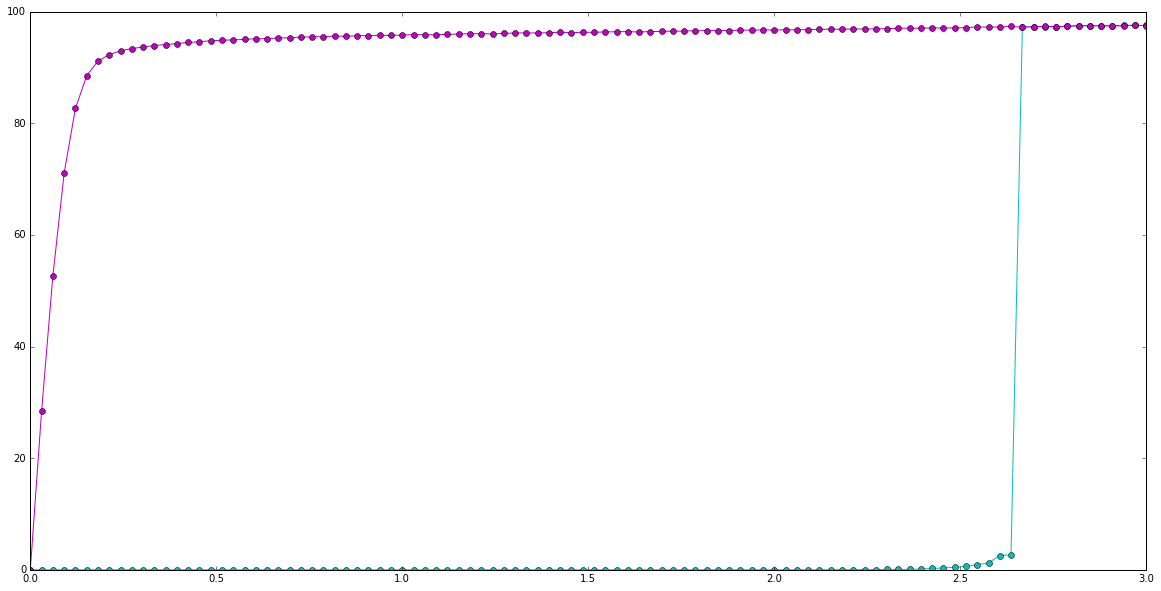

In [5]:
form_sweep= plt.figure(figsize=[20,10])
f=form(3,100,10e-3, mrange=MeasureRanges_I.uA10_limited)
f.to_csv("{}_form_3V.csv".format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
plt.autoscale()
checkR()

                 EI            ET           EV
count  1.000000e+03   1000.000000  1000.000000
mean  -3.918991e-04  71688.063260    -0.750001
std    4.016171e-04      1.365773     0.434097
min   -1.553500e-03  71685.640000    -1.500000
25%   -4.958625e-04  71686.850000    -1.124975
50%   -2.796750e-04  71688.090000    -0.750000
75%   -8.745500e-05  71689.250000    -0.375025
max   -8.500000e-09  71690.410000     0.000000
14363.46848970611
                 EI            ET           EV
count  1.000000e+03   1000.000000  1000.000000
mean   7.489937e-05  71698.192780     0.500001
std    3.150140e-05      1.292406     0.289399
min   -4.600000e-08  71695.890000     0.000000
25%    5.905250e-05  71697.087500     0.250000
50%    9.324000e-05  71698.195000     0.500000
75%    9.391625e-05  71699.310000     0.750000
max    9.434000e-05  71700.430000     1.000000
1062.520476376068
                 EI            ET           EV
count  1.000000e+03   1000.000000  1000.000000
mean  -2.770078e-04  717

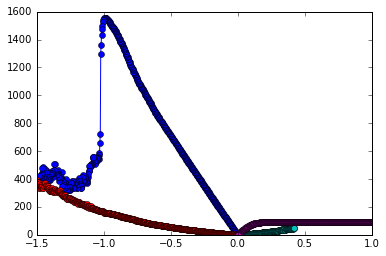

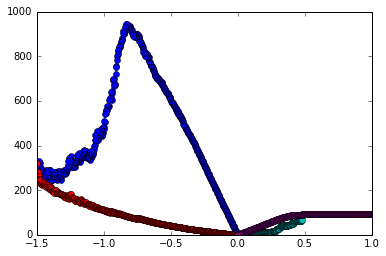

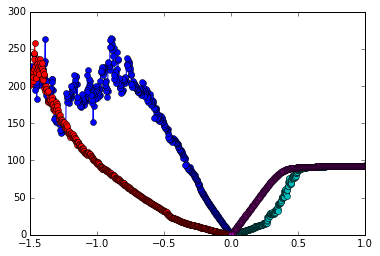

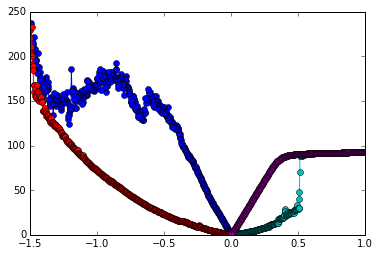

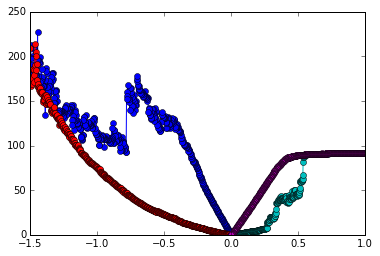

In [6]:
iters=5
for i in range(iters):
    plt.figure()
    plt.hold()
    rt=reset_sweep(-1.5,500,5e-3,gate=1.85, mrange=MeasureRanges_I.uA10_limited)
    rt.to_csv("{}_reset{}_-1_5V.csv".format(
            datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),i)
             )
    checkR()
    s=set_sweep(1,500,10e-3, mrange=MeasureRanges_I.uA10_limited)
    s.to_csv("{}_set{}_1V.csv".format(
            datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),i)
            )
    checkR()
    plt.hold()

Iteration  0
          preReset     postReset        preSet     postSet
count    11.000000     11.000000     11.000000   11.000000
mean   1223.701531  37922.266657  37589.715840  873.161198
std    1176.443020   1233.356686   1973.766127   43.669106
min     832.057060  36221.014493  34656.531532  830.424608
25%     852.947800  37120.819949  35904.841029  847.164180
50%     859.897704  37426.940639  37626.225490  857.030050
75%     881.639396  38598.394430  38575.609031  878.008048
max    4768.898041  39986.338798  41107.594937  966.942828


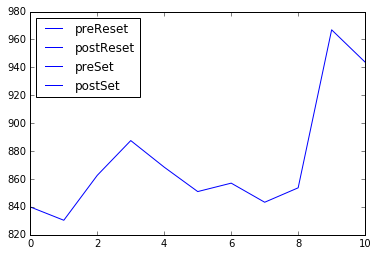

In [7]:
voltage_si='mV'
resetV=-500*unit(voltage_si)
setV=800*unit(voltage_si)

time_si='us'
width=100*unit(time_si)

times=10
slope=0.8
d=check_width(width, times,rV=resetV,sV=setV,slope=slope)
d.to_csv('{}_{}pulses_reset{}{}_set{}{}_width{}{}_slope{}percent.csv'.format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
                                                                            times,
                                                                            resetV/unit(voltage_si),voltage_si,
                                                                            setV/unit(voltage_si),voltage_si,
                                                                            width/unit(time_si),time_si,
                                                                            slope/1e-2
                                                                           )
        )


In [ ]:
baseV = (-500,800)
r,s=baseV
percentages=list(reversed(range(40,101,5)))
rL=[r*i/100 for i in percentages]
sL=[s*i/100 for i in percentages]
pyr=list(itertools.product(rL,sL))
vpyr=pyramid_voltage(pyr, voltage_si='mV', abort_break=False)

Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1790.069803  35545.282443  36905.270911  1741.286933
std    2214.194485   4789.940230   5012.451165  2045.888163
min    1040.261546  22024.677579  24064.310260  1036.475186
25%    1082.814000  35455.314010  36335.843146  1082.481190
50%    1141.143653  36382.575758  36756.510417  1098.943313
75%    1175.457571  38016.276042  39516.560057  1190.997829
max    8463.942648  40147.849462  44074.074074  7906.692980
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1161.664344  37244.409768  36807.968442  1155.793780
std     195.693131   1936.840318   1871.816026   202.918743
min     973.169059  33803.763441  35130.597015   959.518479
25%    1042.100594  36209.129759  35611.281826  1028.540804
50%    1075.116980  37954.106280  35958.333333  1085.454115
75%    1218.94

<IPython.core.display.Javascript object>


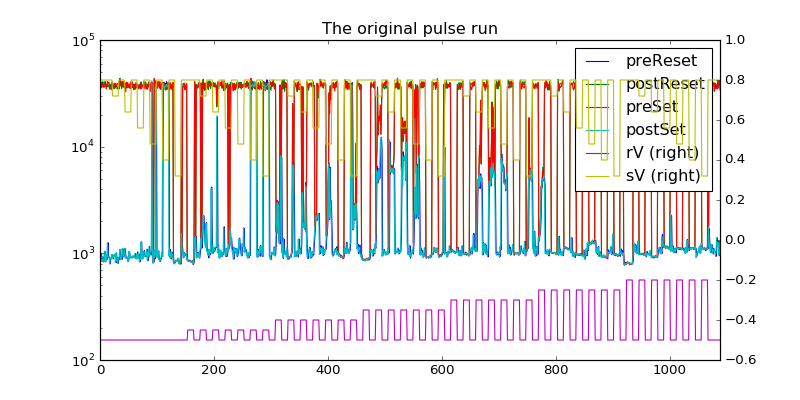

<IPython.core.display.Javascript object>


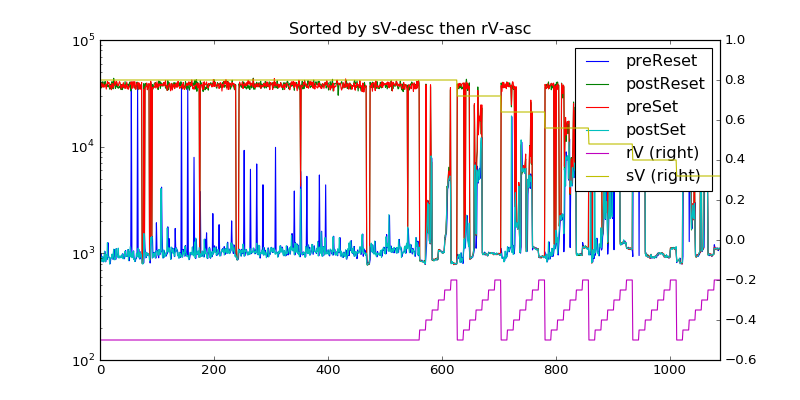

<IPython.core.display.Javascript object>


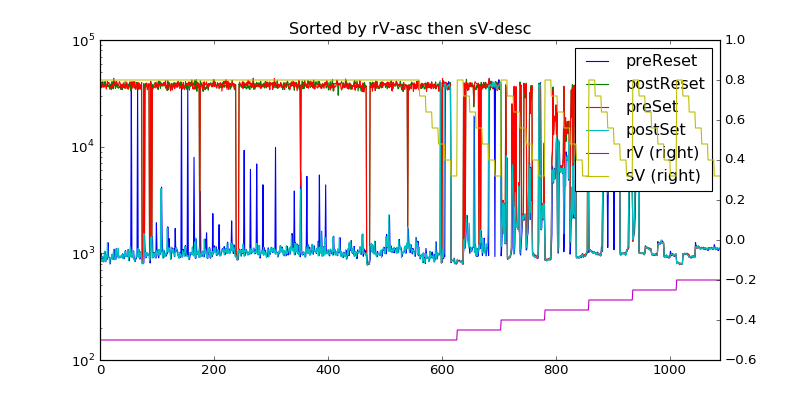

<IPython.core.display.Javascript object>


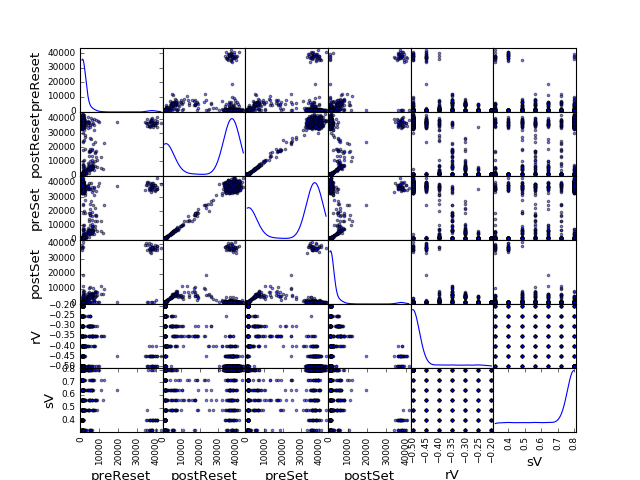

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A570DA0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000F0DA780>]], dtype=object)

In [11]:
%matplotlib notebook
vpyr.plot(logy=[True,True], secondary_y=['rV','sV'],figsize=[10,5], title="The original pulse run")

sortpyr=vpyr.sort_values(['sV','rV'],ascending=[False,True])
sortpyr.index=range(len(sortpyr))
sortpyr.plot(logy=[True,True], secondary_y=['rV','sV'],figsize=[10,5], title="Sorted by sV-desc then rV-asc")

sortpyr2=vpyr.sort_values(['rV','sV'],ascending=[True,False])
sortpyr2.index=range(len(sortpyr2))
sortpyr2.plot(logy=[True,True], secondary_y=['rV','sV'],figsize=[10,5], title="Sorted by rV-asc then sV-desc")


pd.tools.plotting.scatter_matrix(vpyr, diagonal='kde')

<IPython.core.display.Javascript object>


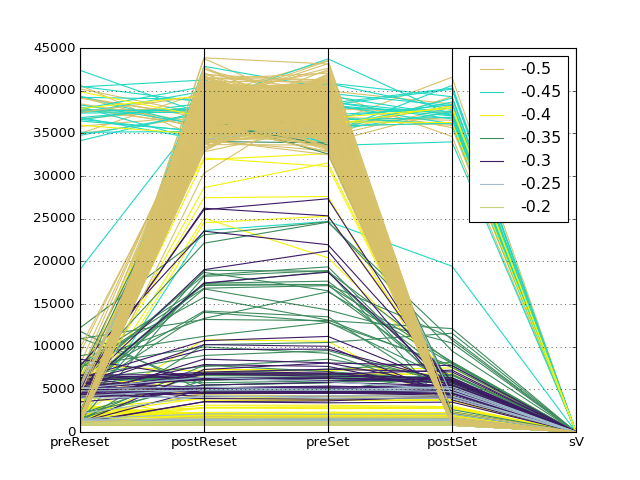

In [15]:
%matplotlib notebook
pd.tools.plotting.parallel_coordinates(vpyr,'rV')

In [ ]:
%matplotlib notebook
pd.tools.plotting.andrews_curves(vpyr,['sV','rV'])

In [2]:
l='''Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1790.069803  35545.282443  36905.270911  1741.286933
std    2214.194485   4789.940230   5012.451165  2045.888163
min    1040.261546  22024.677579  24064.310260  1036.475186
25%    1082.814000  35455.314010  36335.843146  1082.481190
50%    1141.143653  36382.575758  36756.510417  1098.943313
75%    1175.457571  38016.276042  39516.560057  1190.997829
max    8463.942648  40147.849462  44074.074074  7906.692980
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1161.664344  37244.409768  36807.968442  1155.793780
std     195.693131   1936.840318   1871.816026   202.918743
min     973.169059  33803.763441  35130.597015   959.518479
25%    1042.100594  36209.129759  35611.281826  1028.540804
50%    1075.116980  37954.106280  35958.333333  1085.454115
75%    1218.940327  38424.167302  37703.769841  1207.578617
max    1662.911551  39738.095238  40271.464646  1654.066853
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1067.276403  37703.995545  37534.955408  1067.529542
std     253.337342   2014.280310   1873.499057   242.287893
min     909.883682  33303.140097  34346.244131   909.495045
25%     943.118512  36772.300469  36347.619048   950.634543
50%     970.457439  37952.898551  37554.347826   980.934690
75%     998.348892  38571.113533  38767.673924  1003.080924
max    1728.185256  41010.928962  40746.268657  1704.952498
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1104.855633  37384.847536  37713.079464  1117.404315
std     195.265211   2271.168618    986.287066   193.556273
min     892.491875  34068.181818  36353.009259   892.058572
25%     929.663208  35922.310250  36884.064526   957.017532
50%    1061.427887  36705.555556  37516.025641  1069.552732
75%    1254.276781  38372.974537  38359.254992  1256.966403
max    1472.177707  41184.895833  39564.676617  1470.610487
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1087.568963  38085.529153  37333.305933  1079.312221
std     139.907950   1707.771578   2239.417021   139.044902
min     884.130387  35019.047619  33613.281250   871.414267
25%     962.889784  37068.632756  36222.446237   959.577903
50%    1080.561989  38192.488263  37500.000000  1066.221278
75%    1195.259362  39101.190476  38314.008296  1185.595379
max    1309.186477  40953.282828  40803.571429  1283.177836
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1010.770010  38457.949787  36171.411941  1010.400003
std      72.570167   2611.874181   1236.015775    63.696865
min     912.885706  33830.808081  33767.123288   914.394213
25%     956.671717  36648.009950  35678.913127   965.631097
50%     999.027448  38102.564103  36384.803922  1003.329798
75%    1077.494420  41020.909926  37125.747863  1047.806864
max    1127.176230  41976.010101  37531.400966  1122.623207
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1214.538156  37351.893897  37685.837887  1220.080624
std     309.263265   1518.784439   1716.800187   306.584029
min     985.104814  34993.421053  36045.893720   982.582075
25%    1037.992671  36345.139197  36144.224877  1060.174885
50%    1106.013307  37450.000000  36718.750000  1100.600615
75%    1234.558987  38238.042840  39094.311053  1228.466778
max    2024.768499  39574.444444  40406.862745  2029.527516
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1120.495804  35596.513238  34325.631450  1121.440339
std     227.778703  11747.713766  11225.881819   222.728055
min     891.892818    934.643116    926.947557   901.337345
25%     943.678325  36655.390147  36112.255623   938.269404
50%    1037.965365  39588.095238  36525.821596  1065.350749
75%    1257.073272  40822.616186  38669.560185  1227.956090
max    1603.797595  41759.950249  41224.462366  1575.086695
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1041.710181  37596.263550  37946.087933  1035.397914
std      91.028951   1874.247950   1475.751971    91.408260
min     904.076642  34343.055556  35084.635417   893.735178
25%     987.731832  36673.611111  37100.435323   994.075082
50%    1019.088471  37154.411765  37943.121693  1028.312778
75%    1109.162627  38703.358209  39260.796711  1095.559890
max    1182.115783  40891.025641  39858.490566  1202.298113
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1020.035670  37946.369950  38629.206310  1007.433915
std      80.943766   1487.037276   2206.646636    77.404316
min     909.076379  35726.010101  36321.236559   929.381675
25%     963.121407  36783.476209  37177.164623   943.850451
50%    1002.997507  38369.949495  38233.585859   979.395831
75%    1058.937108  38844.616205  38999.118507  1056.429871
max    1175.780060  40036.069652  43761.574074  1145.504155
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1001.516573  37674.936268  38218.467292  1004.170952
std      75.398973   1719.513194   2737.323104    81.754660
min     901.634268  35375.683060  34110.696517   901.785202
25%     944.995276  36379.151776  36656.460345   937.882756
50%     975.967776  37161.904762  38108.465608   979.300027
75%    1073.137813  38445.487741  40351.511672  1084.402357
max    1119.164721  41221.846847  42472.677596  1121.064076
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1101.614942  36968.900391  38126.875533  1102.581501
std     392.169696   2247.574565   2349.745803   396.683696
min     879.563488  32365.384615  33776.255708   867.542036
25%     932.902335  35405.251142  36429.115025   947.462883
50%     974.136316  37131.455399  38366.402116   966.436051
75%     994.351575  38810.410442  39557.539683   993.992167
max    2213.947320  39592.857143  41653.645833  2225.827317
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1042.045890  33980.633551  34237.460633  1035.853469
std     148.193889  10926.841592  10940.872312   148.901125
min     919.487713   1467.189505   1493.527428   915.445302
25%     961.790187  36441.909792  36613.890009   951.360790
50%     999.711716  37118.872549  37193.589744   986.412774
75%    1052.115498  37467.029079  38262.307363  1048.531111
max    1452.079166  41516.393443  39492.063492  1444.297467
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1687.902011  35582.127791  35441.772683  1706.365310
std    1384.952364   9839.142003   9541.797628  1397.976110
min     937.009899   6989.050710   7053.898580   930.171556
25%    1056.745454  36220.486111  36483.777541  1082.321981
50%    1108.407313  38780.637255  38879.487179  1089.542527
75%    1171.795363  39428.835979  39289.923199  1179.644022
max    4949.118892  42526.041667  40036.764706  5089.615766
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1094.636332  37729.433898  38565.644105  1115.054400
std      68.545100   1307.414763   1381.961295    82.885855
min    1006.370477  35277.777778  36862.373737   993.973809
25%    1032.807002  37063.169025  37158.653163  1072.017884
50%    1111.912013  37823.529412  38819.892473  1102.441964
75%    1132.345790  38393.586601  39544.342681  1130.889960
max    1235.824599  39915.441176  40687.500000  1265.288124
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1033.575820  38291.362274  38758.033984  1001.920265
std     141.183008   1515.801669   2215.354048   117.517492
min     920.487689  36589.285714  35794.117647   905.726956
25%     950.219348  37121.746410  36804.341492   940.166424
50%     962.883050  37797.619048  38687.830688   965.212531
75%    1059.138400  39294.697149  40851.385636  1022.510160
max    1353.960405  41461.442786  41621.212121  1316.007320
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean    4353.769844  37517.409033  37844.765322   7264.807233
std    11300.021244   1938.892480   2016.991380  14055.539280
min      884.142688  34357.323232  34357.142857    890.029101
25%      930.563428  36609.102105  36634.535655    942.779106
50%      952.644771  36873.239437  38022.300469    958.514015
75%      973.608855  38498.284557  39002.146440   1007.729898
max    38424.479167  40850.225225  41511.194030  37160.256410
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    4312.451291  34663.500488  34196.962410  1017.128519
std    10963.701698  11195.206487  11104.318834   162.129362
min      835.719899   1406.921261   1385.740723   839.038465
25%      894.327310  36284.469320  35695.217611   913.096504
50%      990.451265  37582.236842  36654.589372   972.628011
75%     1116.214492  39243.617684  38709.500067  1095.572469
max    37365.591398  41006.218905  41275.252525  1402.705783
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean    4491.062446  37593.883540  36563.276800   4688.026471
std    11400.168504   2145.244550   2107.225182  12130.633396
min      931.868773  33463.541667  33523.391813    917.836578
25%      987.389449  36948.263705  35114.510995    965.518239
50%     1011.195117  37875.000000  36848.809524    987.598708
75%     1153.543827  39102.957946  37901.811152   1135.093141
max    38862.433862  40049.435028  40547.945205  41261.904762
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1040.095988  37348.963034  37485.933728  1046.653903
std     124.967840   1973.886801   1611.597506   121.582646
min     935.492417  34190.140845  35035.539216   956.826239
25%     959.116717  36125.631313  36481.771471   977.154258
50%     993.374834  37795.893720  37048.122066   996.366312
75%    1066.272331  38291.742150  38676.370133  1055.071645
max    1357.462681  40664.414414  40097.222222  1365.646728
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   17533.054783  36668.445428  37669.832975  21012.716585
std    18914.159226   2068.257804   1767.162977  19127.079987
min      974.915102  34252.525253  35255.952381    979.854956
25%     1044.982876  35007.005575  36459.887566   1073.985976
50%     1353.769723  36382.575758  37557.142857  35599.099099
75%    37048.488029  37989.417989  38876.649306  37317.351901
max    38718.579235  40247.747748  40838.983051  40239.898990
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    4319.076542  37883.262443  37716.142889  1113.097327
std    10578.891056   1520.206651   1308.608354   212.962156
min      908.278046  34218.750000  35193.627451   892.448530
25%     1000.892002  37390.719365  36722.186947   974.558207
50%     1097.567422  38392.857143  38226.351351  1060.933940
75%     1246.070831  38709.126984  38670.955882  1157.991686
max    36208.920188  39670.698925  39146.174863  1648.501040
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   34616.663631  37440.683760  38250.855178  37858.644294
std    11297.454380   2317.836508   1590.023451   1498.372087
min      995.647918  34814.676617  36156.716418  36006.127451
25%    36287.984758  35745.039019  37512.964775  36462.057387
50%    38024.193548  37085.416667  38165.509259  37539.800995
75%    39155.405405  38506.970357  38575.637326  39028.797591
max    40913.888889  42003.424658  42190.656566  40169.117647
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    4802.307906  37552.208392  37465.265151  1030.430993
std    12479.531649   2104.883482   1414.989332   102.517776
min      902.064444  34403.755869  35122.395833   925.058102
25%      981.917731  36440.008292  36638.230116   952.988217
50%     1021.691409  37363.184080  37046.448087   995.865983
75%     1147.366784  39052.837699  38426.598050  1083.849602
max    42428.240741  41259.887006  39849.033816  1241.438967
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   35087.842056  38563.480148  38321.115133  37293.028432
std    11484.958436   2080.434113   1727.377073   2094.086648
min      934.821655  34616.421569  36465.053763  33772.727273
25%    36959.131993  37110.805458  37009.867010  36085.680469
50%    37982.804233  38909.313725  37791.044776  36849.033816
75%    39306.838768  40356.913919  39586.805556  38199.507618
max    42328.767123  40873.737374  41267.857143  41160.714286
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    4384.638020  34010.614458  33819.028374  1169.849970
std    10618.886259  10683.424484  10531.368930   485.635000
min      958.785862   2588.556057   2559.379100   942.808849
25%      998.790805  35073.484848  34837.455437   997.138305
50%     1063.927452  36720.085470  36751.302083  1033.016050
75%     1092.024812  38337.437753  37988.158613  1052.487107
max    36370.967742  41417.910448  40361.607143  2626.641164
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1030.810234  37472.925719  36944.769631  1028.523713
std     127.605039   1186.341118   2510.345371   124.489720
min     886.071569  34553.240741  33516.927083   868.897682
25%     945.442105  37595.238095  34912.752525   958.473375
50%     977.340177  37822.327044  37321.428571   990.108782
75%    1089.962630  38060.132576  38225.481316  1076.366761
max    1308.583608  38741.935484  41220.657277  1320.447089
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1030.909441  37759.206922  38353.069030  1036.639383
std      98.338864   1768.117952   1293.189376    95.492695
min     901.867269  35824.494949  36396.794872   913.587910
25%     972.750827  36045.125712  37424.550654   957.882259
50%    1023.934801  38121.794872  38622.311828  1033.838636
75%    1073.065287  39333.246528  39395.645646  1081.418340
max    1253.638112  40166.666667  40000.000000  1246.905146
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1049.184101  37919.623767  37250.236552  1045.693753
std     143.596780   1934.998716   1628.666344   142.317442
min     930.652293  35222.602740  34310.483871   926.959819
25%     961.947969  36644.521792  36264.520202   969.635790
50%     998.166036  37585.616438  37280.982906   997.642100
75%    1057.470711  39056.423611  38188.241744  1037.067779
max    1405.418287  41536.069652  39644.444444  1401.998980
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1007.549178  37132.988390  37534.908799  1000.557763
std      53.256594   1500.628150   2243.329502    59.321148
min     954.120539  35140.046296  32954.918033   930.322917
25%     976.465595  36289.367088  36190.921691   959.578510
50%     987.103841  36886.243386  38084.615385   994.515716
75%    1016.295798  37486.416361  39070.226476  1015.522889
max    1143.969615  40478.260870  40820.707071  1141.026926
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1021.499475  37084.037260  36874.269738  1018.400682
std      74.117301   2098.672570   1655.832292    67.174531
min     941.298719  35299.479167  34599.315068   946.799198
25%     967.947016  35619.841616  35713.184932   967.032472
50%     995.627583  36415.492958  36596.244131  1005.658812
75%    1058.695608  37719.703638  37733.434231  1055.289016
max    1164.457034  42288.095238  40483.870968  1130.233981
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1143.071398  34201.170672  34565.459583  1144.668922
std     375.957848  10822.759605  10903.424660   368.829736
min     905.603642   2128.240243   2178.664216   903.505543
25%     967.263047  35376.973965  35632.629870   966.827883
50%    1005.657902  37187.500000  37877.604167  1007.420051
75%    1165.888791  38898.046875  39023.644180  1191.555048
max    2236.132833  40658.783784  40568.075117  2203.430864
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1033.163621  37175.552771  37482.451500  1036.910899
std      78.190286   1727.583108   1953.802151    67.738208
min     943.310377  33422.316384  35828.358209   953.186448
25%     971.145652  36584.201389  36044.871795   982.286595
50%    1010.631898  37348.039216  37013.888889  1017.417228
75%    1092.845382  37618.166763  37890.965880  1095.779882
max    1153.109396  40650.252525  42329.234973  1146.594499
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1129.864504  33853.756842  34296.280050  1127.848945
std     291.563370  10784.158330  10920.372948   294.315533
min     905.102303   1877.322348   1848.945102   890.695116
25%     920.179159  35306.746032  36142.101990   910.577354
50%    1071.268162  36432.539683  37512.626263  1073.639818
75%    1167.072580  38246.107950  38479.166667  1163.070472
max    1869.612927  41112.903226  40650.252525  1876.925726
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1110.145759  34707.959056  34237.179806  1120.331245
std     188.493516  11084.372045  10990.820195   182.094168
min     927.005733   1531.680370   1525.238640   921.617433
25%     989.732790  36784.682765  35570.000000   992.128696
50%    1025.463581  37350.490196  37720.394737  1064.871347
75%    1145.354268  38531.234954  38408.718741  1151.953695
max    1507.492292  41300.000000  41210.317460  1482.427614
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1092.280819  36716.702315  38427.577345  1155.009823
std     151.497492   1628.704989   2196.171201   249.421309
min     958.345449  34223.429952  34397.435897   976.732448
25%    1003.487923  35604.311343  37123.775064  1012.246904
50%    1030.806412  36801.932367  38072.222222  1031.749252
75%    1125.362797  37433.479532  39409.487613  1169.541436
max    1500.240647  39583.333333  42367.724868  1772.840262
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1284.613743  35264.777406  34534.342716  1218.347860
std     308.729038  11251.482218  10979.444995   250.133440
min     915.610416   1891.976022   1833.319783   916.591253
25%    1125.918843  36464.423723  36144.313643  1112.202339
50%    1204.573256  38582.175926  37393.459916  1178.797293
75%    1369.615684  39203.950486  38612.016908  1264.990469
max    1851.932939  42761.904762  41106.060606  1844.559562
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1125.289089  37775.031051  37961.478739  1124.030769
std     289.552190   1494.824127   2064.187554   305.701425
min     948.981419  34093.137255  32922.794118   943.025612
25%     974.808316  37258.942526  37351.897352   968.718874
50%    1001.826838  37862.318841  38208.333333  1022.543789
75%    1127.472665  38607.230392  38897.143975  1090.133354
max    1937.141933  39643.518519  41346.153846  1982.906256
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1091.103227  38139.713782  37978.881611  1078.537528
std     135.180922   1303.883277   1776.740871   137.043003
min     958.413131  36467.391304  34466.911765   952.964965
25%     990.936983  37234.755044  36946.517413   987.362064
50%    1081.834404  37957.207207  37751.141553  1027.073309
75%    1133.379115  38938.575694  39561.085116  1121.391775
max    1411.411455  40416.666667  40034.722222  1415.107289
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1174.438360  36899.088923  38832.361860  1221.482683
std     149.269783   1486.966633   1500.489019   158.300557
min     910.489348  35668.055556  36589.912281   912.511316
25%    1135.489829  36028.332564  37754.050926  1142.570255
50%    1175.342598  36146.766169  39438.657407  1190.170407
75%    1272.470000  37083.333333  40019.779266  1311.115912
max    1431.551934  40079.022989  40816.091954  1467.079656
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1300.862527  34612.122432  35406.050652  1283.161133
std     785.669631  10455.474117  10603.565054   781.489953
min     920.008540   3804.858711   3919.795423   929.141496
25%    1008.010284  35501.797242  37372.252530   991.999216
50%    1038.499088  37776.515152  38426.616915  1058.776585
75%    1166.238829  38926.382368  40000.586854  1128.107413
max    3639.117998  41011.904762  40883.838384  3626.436369
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1072.472740  36189.199682  37557.747355  1061.751980
std      82.249006   1471.907345   1588.760512    81.285212
min     931.566132  34477.699531  35646.135266   933.194449
25%    1025.038185  35049.139070  36486.983809  1010.561278
50%    1066.069938  35976.190476  37203.463203  1060.838247
75%    1141.549304  37032.007929  38265.674968  1121.717304
max    1175.970469  39237.089202  41039.215686  1175.750983
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1105.899030  37628.633920  37068.234369  1108.020419
std     105.198272   2276.874970   2502.586644   106.452096
min     985.239680  32833.333333  33998.737374   964.507916
25%    1026.214076  36783.967391  35329.184704  1035.934282
50%    1096.026112  37919.312169  36514.639640  1069.348946
75%    1188.334195  38853.987455  38351.064825  1190.485609
max    1259.348673  41009.389671  41755.050505  1287.259713
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1098.215668  38004.313047  36326.093029  1111.546666
std      73.516668   2450.334583   1594.576841    68.050548
min     990.855314  32968.905473  34023.224044  1002.869539
25%    1051.989042  36652.207002  35360.212418  1074.658537
50%    1091.748867  37643.939394  36115.196078  1107.763960
75%    1122.961223  39627.210668  37158.459596  1138.321831
max    1263.433305  41919.398907  39043.427230  1261.674521
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1057.973929  38219.975475  37495.439262  1054.175239
std      83.272877   1499.447275   2019.191519    74.062201
min     913.428242  35376.811594  34416.666667   922.370524
25%     998.940287  37585.455658  35990.679825  1000.988173
50%    1060.217553  38333.333333  37709.490741  1065.122663
75%    1116.665673  39081.547619  38337.471942  1113.692648
max    1163.091386  40590.476190  40945.273632  1160.532632
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1242.349034  34393.876546  33878.793020  1254.756117
std     296.494650  10922.820438  10790.257479   280.442943
min    1025.596647   1921.655106   1945.089791  1024.953284
25%    1062.587900  35492.034314  34935.462536  1085.076909
50%    1081.793487  38166.666667  36688.356164  1131.826782
75%    1265.614088  38827.951121  38341.117216  1272.377008
max    1928.764065  39824.712644  40785.024155  1895.693412
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   17535.384114  36611.539608  37963.151464  21670.627105
std    18576.620989   1080.753926   1583.509924  19429.405784
min     1067.035100  35630.952381  35680.365297   1083.200406
25%     1378.421452  35864.599334  36936.961207   1493.541235
50%     1968.362869  36094.202899  37759.146341  34646.825397
75%    36717.567227  36906.773977  38583.543771  38627.231216
max    39732.142857  38915.509259  41047.297297  41004.975124
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    4477.531680  37604.079988  38680.469340  1095.204120
std    11192.215723   1932.435239   1946.640236   109.790432
min      985.996283  35736.111111  34124.293785   994.190603
25%     1044.061946  35961.820440  38125.000000  1040.125154
50%     1090.270988  37577.294686  38661.458333  1076.005598
75%     1130.546554  38091.132569  39437.875375  1107.166295
max    38221.428571  41977.777778  41769.841270  1397.287450
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   27362.537412  37119.364218  37220.590341  30535.901027
std    16864.222559   2188.375456   1697.224689  14591.045473
min     1093.473731  34287.162162  34917.989418   1099.338751
25%    18719.069455  35438.030436  36330.958946  34895.638538
50%    36689.743590  36275.252525  36892.361111  37043.478261
75%    37094.162876  39263.171800  37672.862998  37841.595442
max    38852.459016  40294.191919  40739.942529  38870.056497
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    4658.526856  38024.319808  38077.021772  1184.904610
std    11496.625155   1864.832700   1842.155315   114.849495
min     1037.466189  35448.232323  35153.846154  1040.486528
25%     1097.540973  36463.275613  37343.641148  1092.678989
50%     1191.701362  37977.168950  37812.500000  1172.174221
75%     1333.831911  39163.587849  39141.217459  1277.346336
max    39320.512821  41298.701299  41111.111111  1361.030306
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   34271.553937  37140.940938  38118.855949  38243.072413
std    11193.717601   2027.872994   2206.816579   2008.050051
min     1177.544486  34173.280423  35204.545455  34307.432432
25%    35638.026225  35922.727910  36426.685068  37244.718310
50%    36099.537037  36756.944444  38388.480392  38602.150538
75%    39368.949916  38274.179561  39350.395264  39076.058201
max    41154.411765  41676.190476  41988.095238  40958.994709
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    4712.095598  36405.565069  37157.150725  1236.637713
std    11445.072845   1492.068333   2236.239031   306.856896
min      975.910705  33781.250000  34425.675676   986.974480
25%     1029.215006  35688.703441  35830.020958  1017.919929
50%     1173.551742  35772.300469  36535.388128  1053.989740
75%     1627.124903  37314.335155  38407.961460  1420.521713
max    39208.333333  38853.571429  40997.652582  1763.418900
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1244.887915  34665.594415  34141.660149  1294.797547
std     251.823859  11166.290023  11006.192180   249.811376
min     973.818873   1559.430992   1483.736142  1020.222167
25%    1041.830673  36789.572310  35502.012072  1057.739258
50%    1143.228790  37609.195402  37580.845771  1219.127598
75%    1461.385949  39095.512821  38614.660796  1523.127948
max    1690.282040  40912.698413  40736.301370  1695.755858
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1147.008857  36662.757532  37194.492365  1101.119229
std     204.772140   1685.814391   1856.683971   166.485482
min     932.165496  33000.000000  34433.114035   940.634242
25%    1002.321412  35814.818226  35943.568415   997.451316
50%    1084.648497  36734.972678  36822.139303  1020.456226
75%    1255.458060  37680.901997  38864.734300  1160.547306
max    1536.320256  39137.179487  39757.882883  1461.076831
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1132.388509  36675.705404  37695.289610  1146.726764
std     148.938309   1508.106438   1767.562425   137.426606
min     900.990813  34209.956710  34851.010101   894.026544
25%    1044.127097  35735.930736  36939.147080  1099.672480
50%    1147.511356  37022.300469  37300.469484  1143.242719
75%    1174.707815  37431.592040  38695.414164  1187.500835
max    1470.902216  39399.801587  40943.287037  1444.626112
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2179.625604  25066.516520  25125.619442  2064.981084
std    2475.937271  16646.635891  16879.931244  2133.042457
min    1019.481001   1512.666728   1516.000536   996.550715
25%    1134.493171   7077.215614   6487.583571  1100.116276
50%    1254.398134  34963.114754  34685.990338  1270.788472
75%    1774.392656  36988.979469  38021.198830  1777.337802
max    9509.459087  39950.704225  39381.840796  8337.269756
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1513.766861  30646.180996  30596.533450  1535.624373
std     294.605642  14649.802516  14442.153830   270.647330
min    1074.727272   1789.503202   1816.537596  1200.562979
25%    1289.013214  31968.405036  32934.810986  1341.803336
50%    1492.106583  37201.636905  36875.000000  1489.833160
75%    1724.199340  39352.367262  38355.099502  1723.899478
max    2041.319248  39944.444444  39886.473430  2058.538786
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1204.081369  38364.002381  37048.232244  1168.594297
std     318.158065   1713.495543   2061.905130   310.193791
min     978.591406  36126.760563  34726.368159   958.246282
25%     996.943146  37304.794521  35451.388889  1002.671747
50%    1084.990828  38008.454106  37234.299517  1075.720597
75%    1299.208271  39070.203081  38016.311813  1187.772421
max    2062.300290  41423.611111  41653.439153  2025.943767
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1204.212986  37714.679915  37164.825121  1275.293959
std     248.177602   2029.297222   2375.549337   284.554064
min     950.217551  33339.843750  32614.942529   982.465564
25%    1035.713866  36486.971831  36927.447552  1096.553285
50%    1160.881268  38425.925926  37234.299517  1190.217673
75%    1294.979810  38980.392157  37511.841168  1317.872765
max    1839.167027  40378.415301  42505.208333  1883.010329
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1155.759625  38988.445220  37715.863228  1082.380619
std     223.886338   1094.519819   2005.347162   116.198178
min     937.499269  37452.380952  34628.787879   939.285167
25%    1034.060638  38355.220985  36470.251502  1018.752063
50%    1059.904124  38785.714286  37946.859903  1038.302274
75%    1204.121829  39685.990338  38454.389238  1136.162938
max    1724.934424  41233.108108  41815.476190  1298.626503
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1242.222319  37421.518335  37265.406507  1260.446124
std     269.432168   2521.373215   2150.507567   272.216140
min     977.462584  33271.164021  33459.595960   967.893130
25%    1080.084157  35832.976310  36293.855042  1130.686556
50%    1185.791014  37621.527778  37226.715686  1195.644211
75%    1317.434772  39398.109244  38505.184332  1318.921913
max    1941.124888  41119.047619  40869.565217  1992.141951
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1113.131997  36114.475670  37818.407604  1106.208962
std     177.833146   1911.133671   2290.990141   179.931110
min     921.680801  33689.743590  34715.962441   922.918841
25%    1016.319451  34825.810185  36494.148507   993.130983
50%    1077.488416  35879.166667  37203.980100  1066.717928
75%    1159.209309  36844.691506  38599.018353  1190.321275
max    1569.168346  39797.979798  42997.747748  1541.694097
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1361.353091  37785.878079  37998.676198  1363.787224
std     624.324704   2407.245911   2114.100735   619.922189
min     965.310514  34912.760417  35323.059361   964.790618
25%    1083.167080  36013.558201  36211.627493  1090.428962
50%    1140.162367  37107.981221  37743.589744  1147.280969
75%    1278.822130  39357.361897  39665.321109  1296.133362
max    3146.699854  41772.486772  41320.105820  3133.899559
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1192.302962  37035.136874  37605.174158  1192.087594
std     234.842076   2750.007387   1982.663351   233.990925
min     982.796486  32131.840796  33393.192488   982.147749
25%    1016.081083  36104.600694  36829.723289  1022.432530
50%    1097.540484  36356.807512  37910.256410  1080.284915
75%    1307.097296  38983.386638  39110.505287  1309.039083
max    1703.000870  41139.705882  40000.000000  1677.408948
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1252.074052  31122.301385  31824.185293  1353.761443
std     327.071878  14733.613971  14952.164908   410.354755
min     984.736345   1425.277432   1471.375317   985.446827
25%    1043.887610  34963.912965  36621.244131  1093.665737
50%    1173.861710  36438.172043  37167.792793  1177.519720
75%    1315.525680  38516.595353  39901.129944  1405.138592
max    2132.799341  41944.444444  40683.060109  2206.307968
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1342.432217  34081.594537  34922.810602  1258.145891
std     451.075850  10817.633440  11075.857344   396.948985
min     956.766625   1945.905076   1899.137014   962.677999
25%    1019.863945  35565.567993  37251.515509  1026.776337
50%    1145.740609  37424.242424  37397.260274  1103.053126
75%    1644.585070  37953.739368  38813.820243  1249.401159
max    2128.879976  41619.718310  41076.719577  2132.722358
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1292.206541  37735.288902  38153.302449  1293.432202
std     344.276860   2411.194038   1558.164107   354.792787
min     986.607722  33897.435897  35491.293532   987.853290
25%    1127.443623  36594.967532  37009.459744  1119.773389
50%    1202.866568  37869.047619  38214.285714  1193.278304
75%    1325.074000  38681.855400  39367.584426  1326.140918
max    2268.691840  42022.058824  40873.809524  2296.359944
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1403.299478  34949.393668  34063.147116  1405.078496
std     465.547623  10908.989065  10582.404489   476.914864
min    1011.095237   2465.928146   2413.729286  1002.051972
25%    1111.834983  36067.536003  36097.746394  1140.854051
50%    1276.569539  38457.031250  37381.756757  1242.302922
75%    1385.024928  39276.293683  38048.160173  1384.829903
max    2381.765066  41069.651741  38849.264706  2453.072637
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1185.615785  33475.985281  34435.698050  1191.790299
std     199.381086  10648.846283  11080.734606   172.831520
min     968.364282   1715.291732   1717.142401   963.526596
25%    1088.222624  35269.560185  35434.212818  1105.644000
50%    1144.388005  36151.620370  37265.151515  1171.009972
75%    1230.836608  37621.965453  38938.095238  1221.519603
max    1727.785551  40051.282051  41930.555556  1645.221232
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1559.782722  34644.997432  34918.218157  1541.327722
std    1231.796889   9870.598185  10007.051285  1222.564300
min    1050.559835   5473.715419   5473.834391  1021.457605
25%    1102.992232  36027.845372  36651.299952  1072.955812
50%    1186.988218  37300.995025  38057.359307  1149.374074
75%    1337.258619  38209.303061  38980.566281  1330.182259
max    5258.696697  42115.942029  41256.720430  5209.202698
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1081.625499  36953.324670  36385.000111  1097.985062
std     105.323551   2149.903642   1593.581205   120.582633
min     981.244706  33795.662100  33194.444444   988.069716
25%    1032.009891  35613.136242  35456.586022  1015.904219
50%    1051.199065  36865.497076  36855.022831  1062.997584
75%    1092.327365  37501.808449  37131.717939  1138.971182
max    1371.248828  41580.687831  38706.709957  1385.622028
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1290.419486  37813.644211  37556.698608  1280.745322
std     305.710804   2066.663365   2245.700900   302.514383
min     985.113601  34356.164384  34027.777778   999.694219
25%    1067.864030  36401.785714  36402.192493  1080.617960
50%    1215.615912  37677.380952  36559.523810  1177.563569
75%    1392.946434  39230.509104  39470.410628  1372.363948
max    1916.972074  41043.715847  40948.717949  1912.534687
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   14380.884709  35237.328256  34638.989124  14533.624067
std    17984.835808  11279.892489  10979.111348  18227.193787
min     1005.485119   2057.620248   2061.935706   1020.469540
25%     1156.097213  35954.997997  36612.884964   1155.010681
50%     2040.848778  36953.431373  37105.633803   2098.782701
75%    36302.361300  40302.617521  39235.936308  35925.291219
max    37909.836066  42840.909091  40631.720430  39368.489583
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1135.413978  37885.100745  37357.803801  1138.601761
std     182.622158   1605.748004   1745.534528   185.340512
min     966.327442  34687.500000  33907.004831   967.135624
25%    1032.019516  36969.483568  36259.389905  1022.183485
50%    1057.748287  37944.444444  37644.444444  1045.365643
75%    1168.490872  38980.815037  38586.018770  1194.900918
max    1563.572299  39974.747475  39604.166667  1562.368736
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   27960.559416  38232.004153  37947.189237  27324.277722
std    17277.793514   1599.734269   1021.968345  16945.079432
min     1039.691380  35338.164251  36319.230769   1044.493957
25%    18708.271676  37241.460659  37297.203196  17329.981726
50%    37334.558824  38493.055556  38071.111111  36419.082126
75%    38437.476081  39145.329707  38684.211832  37460.078348
max    39854.166667  40764.285714  39214.285714  39766.908213
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1090.023542  38011.291090  36630.936469  1098.882689
std     153.080275   1914.474304   1752.236828   155.678021
min     895.372386  35294.776119  34120.772947   901.589931
25%     996.352444  36744.980850  35580.031080  1002.808087
50%    1079.474039  37630.952381  36587.301587  1072.948943
75%    1112.740273  39143.880208  37759.232026  1177.331123
max    1430.372858  42083.333333  40269.607843  1382.752707
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   31602.182474  37482.964520  38609.661576  33845.948669
std    15051.329029   1182.694635   2196.124247  11033.191490
min     1191.287483  36260.582011  35506.329114   1184.604118
25%    37068.265231  36932.564464  37140.960452  34972.756410
50%    37820.601852  37364.444444  38666.666667  37558.080808
75%    38987.516829  37651.778199  39833.822570  38211.613304
max    39688.461538  40669.014085  42076.612903  40791.062802
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    4809.734628  33691.754174  35072.724578  1167.568123
std    12096.823692  10547.708034  11073.491868   326.985859
min      976.876590   2127.086585   2178.893791   982.278352
25%     1032.064701  35499.537037  36784.589377  1022.247698
50%     1054.844176  36500.000000  37355.721393  1060.914941
75%     1111.976185  37798.067356  38874.415732  1125.111505
max    41268.656716  38676.923077  42141.025641  2129.039603
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1370.064831  17477.623791  18090.455440  1390.101392
std     318.274497  18707.449082  19414.999542   312.171724
min    1075.994197   1097.774857   1086.757263  1088.600123
25%    1188.929977   1220.615613   1232.112882  1189.975368
50%    1270.580227   1347.444628   1327.649120  1312.071419
75%    1467.945569  35816.210046  37619.348244  1491.063562
max    2201.574598  39357.487923  40602.339181  2173.854185
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1348.752889  37921.925375  36985.498730  1353.519714
std    1001.046639   1913.868444   1723.294093  1001.894281
min     869.757770  34394.366197  34464.646465   850.577431
25%     936.589422  36879.668160  35979.553650   945.186228
50%     990.236263  38147.619048  37412.935323   984.237990
75%    1176.027487  39331.693484  37891.537267  1214.660741
max    4317.094117  40338.235294  40094.696970  4320.266279
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1526.066461  26365.562389  27478.686296  1553.196109
std     463.264055  16029.367609  16777.644705   456.191283
min    1046.307929   1403.616380   1429.771662  1035.228793
25%    1224.377040  17345.366722  17657.967006  1237.937536
50%    1401.174084  35655.864198  36570.422535  1503.432539
75%    1658.284492  36558.704096  38047.451375  1679.831144
max    2554.761138  37143.640351  39931.693989  2537.460515
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean    2566.811267  36464.177420  37304.311344   2500.710788
std     5246.056842   2456.767742   2596.081761   5081.413842
min      833.349130  31080.208333  32303.652968    825.093957
25%      901.225838  35453.811029  36296.111111    894.112081
50%      926.753053  36621.693122  37390.277778    940.593770
75%      999.112955  37989.718615  38177.614379   1000.317415
max    18373.137350  40279.947917  42096.774194  17815.148912
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1549.457401  25548.274011  24970.055785  1543.491875
std     247.250550  19105.082558  18669.377430   259.488219
min    1204.302943   1302.489800   1270.093482  1194.736662
25%    1405.896048   1621.370987   1625.420380  1350.198471
50%    1488.815664  39458.333333  35997.267760  1487.791648
75%    1717.314836  39585.595573  39199.572957  1734.796687
max    2046.645107  40335.978836  40561.594203  2024.839649
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1138.979736  34652.858211  34185.801983  1151.121068
std     307.564805  11039.760695  10838.841118   309.680162
min     880.787229   1951.284838   1872.961936   850.923720
25%     967.938197  35934.643400  35787.501776   990.635891
50%    1014.573038  37479.957806  37277.380952  1004.176284
75%    1174.829479  38945.628415  38644.791161  1229.559296
max    1928.991322  41640.625000  39276.255708  1890.007199
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1470.850930  28645.732630  27640.675073  1491.180039
std     637.507669  17051.447704  16437.065529   631.670566
min     996.713886   1691.965625   1730.102901   978.366905
25%    1040.448638  19654.469492  17982.315028  1036.444033
50%    1210.584673  38169.191919  36967.136150  1222.045011
75%    1641.240357  39098.759847  38025.906968  1700.454353
max    3173.102714  39946.236559  39141.791045  3120.330286
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1184.655321  38346.831941  37250.290583  1123.271743
std     293.972600   2337.183822   1599.533954   225.722374
min     916.892996  35974.637681  34530.516432   901.242797
25%     969.570102  36842.866162  36161.928680   974.190267
50%    1094.607394  37453.051643  37664.141414  1084.739035
75%    1262.552533  39153.005464  38194.230769  1210.794154
max    1747.281112  42890.625000  39768.382353  1681.046389
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1208.649506  14838.813829  15324.614541  1235.357261
std     214.946327  18789.019653  19489.572127   227.920930
min     976.519289   1114.281402   1114.753700   967.458611
25%    1107.843079   1223.752116   1207.002373  1126.432664
50%    1190.233402   1461.897785   1473.014120  1205.169410
75%    1228.410281  36770.200822  38008.420304  1229.939668
max    1804.626199  41033.602151  41914.141414  1827.723631
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1150.540579  34715.870284  33713.008829  1100.882525
std     296.323010  11160.137031  10872.854165   282.127355
min     883.494075   1801.304606   1776.742899   885.369178
25%     923.831990  36101.792279  35599.866163   908.276531
50%    1064.579450  37936.827957  36512.096774   966.675858
75%    1313.994791  38816.921701  38199.634362  1183.632322
max    1812.818486  42082.191781  40555.555556  1778.172622
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1692.351810  24905.721759  25009.663331  1730.334274
std     753.117061  18063.891313  18212.000762   706.535745
min     936.624013   1210.568462   1190.589674  1124.143921
25%    1163.127029   2997.030660   2954.365927  1250.793236
50%    1525.602894  36158.854167  36052.238806  1517.039863
75%    1977.965549  38767.814010  37706.083725  1990.352218
max    3440.345536  39952.956989  43140.096618  3396.167416
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1115.369848  37964.207724  37347.511352  1086.866002
std     168.442465   1734.903115   1769.133258   147.721557
min     905.777328  35579.710145  34674.603175   908.964319
25%     963.289693  36563.555329  36403.571429   973.634547
50%    1113.871467  38583.333333  37324.626866  1065.206278
75%    1213.655746  39219.147105  37990.850284  1153.707511
max    1423.165772  40848.484848  40176.940639  1399.002664
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1366.431543  17272.755736  18603.821910  1360.820861
std     333.444943  18137.615041  19627.602616   329.217694
min     990.391121   1084.384079   1095.707626  1000.111154
25%    1133.483328   1542.857365   1555.732796  1133.515137
50%    1265.160728   2079.508839   2187.585318  1252.901682
75%    1541.520720  36007.246377  38972.044665  1560.947661
max    2101.909903  38465.277778  40625.000000  2096.833374
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1013.748783  38100.152190  37722.261120  1025.514444
std      79.172267   2031.055559   1717.222393    87.622793
min     857.175436  35550.847458  35576.131687   858.622514
25%     979.377719  36685.943337  36616.249559   962.275862
50%     999.133906  37220.588235  37738.095238  1025.715083
75%    1051.863650  39708.379909  38417.060583  1094.987122
max    1139.406909  41217.948718  41644.444444  1154.788982
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1691.145621  20931.792803  21897.018620  1768.143001
std     797.312347  17868.325839  18872.189424   819.306582
min    1101.625667   1473.744369   1508.054356  1129.743733
25%    1303.690778   2138.908553   2151.186781  1367.900893
50%    1404.784386  35377.314815  35220.238095  1466.460305
75%    1598.919795  36052.952722  38648.498579  1709.536543
max    3799.090954  37933.593750  41398.401826  3981.036419
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1242.948982  38251.271137  36762.991958  1184.012967
std     354.681543   1442.738876   1639.121403   312.024962
min     930.917452  36293.532338  34492.187500   952.067045
25%     999.033780  37445.233586  35658.496732  1005.603292
50%    1025.557138  37685.990338  36692.401961  1031.267583
75%    1440.695202  38957.172856  37829.517974  1222.852390
max    1946.433325  40779.850746  39340.796020  1970.782930
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1572.374916  24949.548177  24564.262273  1654.380331
std     870.358460  18021.963216  17728.938466   824.757982
min     957.436650   1495.497728   1466.666290   937.680604
25%    1081.833630   3001.817014   2974.459412  1124.826929
50%    1165.506405  36377.252252  36521.505376  1493.893584
75%    1623.283661  37980.614144  37546.960383  1864.457686
max    3974.405524  40436.904762  39088.235294  3804.249340
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1294.003879  36548.022423  37482.741082  1223.300751
std     402.683203   1826.557702   2303.291595   309.726797
min     844.166473  34505.952381  33363.387978   859.667714
25%    1012.611315  34722.762997  36410.256410  1007.443326
50%    1191.349276  37509.803922  38358.974359  1194.512140
75%    1443.515565  37984.135611  38976.452584  1311.816296
max    2065.390038  39078.358209  40322.580645  1946.642988
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1233.453986  17953.956671  17498.320352  1231.885278
std     290.660613  19065.189003  18564.827274   288.470946
min     927.421586   1135.703143   1102.017398   938.943231
25%    1023.319929   1253.189905   1268.184373  1028.205221
50%    1210.018566   1878.752567   1856.672040  1169.529858
75%    1269.848724  37392.208246  35077.162266  1277.475458
max    1869.431678  40398.809524  40019.531250  1875.983837
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1263.040990  33598.276918  34784.217100  1274.498114
std     449.056658  10906.274250  11171.691653   453.639366
min     906.159432   1627.651326   1610.183362   924.946511
25%     974.341876  34834.340586  35885.515873   981.915063
50%    1024.754947  36365.384615  37631.720430  1031.709484
75%    1403.051430  37714.409534  39500.734035  1411.645432
max    2102.469337  41739.130435  41489.898990  2132.115226
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1422.250825  20800.340298  20810.987744  1443.007762
std     291.673495  18660.928941  18696.375435   288.123677
min    1064.348817   1259.249063   1309.670479  1041.456003
25%    1267.070596   1448.811633   1464.586439  1287.334605
50%    1333.701905  32300.675676  33405.303030  1391.800142
75%    1467.931692  37144.597070  36782.738095  1484.733202
max    2069.494542  39632.352941  41243.781095  2050.692523
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1638.513511  35019.027630  33657.726737  1595.229069
std    1875.632614   9494.781513   9217.283682  1803.442028
min     877.074406   6938.396571   6749.491930   876.974251
25%     982.102016  36229.700855  33474.464699   975.233292
50%    1075.201960  38292.483660  36237.089202  1056.474309
75%    1177.838644  39016.280566  37496.393035  1172.538764
max    7273.522501  40810.714286  39908.675799  7022.234030
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2204.483740  15756.161486  15679.142512  2401.811210
std     970.022875  17881.782256  17790.564575   981.661569
min    1220.541211   1472.952887   1448.494374  1249.482685
25%    1537.790760   2818.500320   2815.012910  1634.592138
50%    1766.888532   3712.093850   3736.260811  1943.176691
75%    2833.596450  37543.058517  36280.628869  3288.601383
max    3945.228026  39457.070707  40288.793103  3957.717716
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1313.434857  37782.165745  36273.188761  1093.930137
std     766.276691   1238.533267   1883.980786   107.947343
min     967.773892  36471.774194  33589.285714   948.607708
25%    1017.799131  36863.010112  34836.741728  1024.301518
50%    1058.002826  37342.723005  36059.859155  1064.303298
75%    1164.891651  38867.458647  37927.658942  1153.212769
max    3606.411876  39726.775956  38870.892019  1323.896300
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   24288.646882  37417.320609  37544.992054  24565.005111
std    18460.370744   2211.223255   1573.351255  18750.022274
min     1031.609348  32432.835821  35169.444444   1025.668751
25%     1100.510707  36216.639047  36412.044779   1130.252016
50%    36506.944444  37836.757991  38053.278689  36292.237443
75%    37483.203821  39317.565359  38566.629129  39442.985827
max    40894.179894  39700.000000  39939.153439  41069.010417
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1208.996704  34380.367713  32924.085100  1194.675266
std     269.633352  10867.941685  10560.233462   262.098612
min     938.886131   1891.165654   1850.725751   950.032673
25%    1068.398709  36085.061074  33598.420926  1041.606624
50%    1096.907786  37324.879227  35779.761905  1097.869504
75%    1288.033567  38514.207807  38087.622549  1259.823236
max    1914.967787  39672.885572  38878.676471  1891.055145
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2487.436544  19004.298228  19126.598005  2774.708388
std     913.676998  15667.190563  15915.189456   944.689351
min    1041.756893   1504.374159   1499.659297  1508.912666
25%    2094.013235   5283.423673   5237.425541  2220.978888
50%    2399.750995  10970.101930  10247.356879  2515.204424
75%    2666.760661  34663.009471  35995.444308  3164.697830
max    4327.255692  37868.055556  36803.728070  4440.029875
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1583.716435  30828.249827  31602.116056  1342.395451
std     952.505838  14560.211004  14895.359850   374.530848
min     997.114839   1620.522275   1714.469338   989.614405
25%    1082.081498  33577.432385  35273.482779  1074.330828
50%    1134.304149  38006.410256  36517.676768  1154.161441
75%    1674.164172  38911.880813  39877.639113  1544.728893
max    4237.126312  39805.107527  41480.769231  2035.360629
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1591.085782   8469.836446   7725.583440  1585.717730
std     342.568093  15166.144914  13475.265978   367.257801
min    1213.722186   1451.457233   1429.037506  1220.321977
25%    1452.291138   1508.952315   1519.653733  1445.413981
50%    1552.267566   1551.113920   1557.797720  1540.255695
75%    1647.862048   2137.554132   2181.586725  1581.741820
max    2500.562252  39818.693694  35230.225989  2599.553723
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1225.387685  38472.652819  38092.068061  1273.427800
std     177.290591   2136.288338   1497.420098   278.313810
min     958.137109  35597.014925  34587.500000   956.023193
25%    1129.859077  36840.345765  37519.806338  1133.350274
50%    1173.449547  38293.918919  38401.826484  1181.493176
75%    1352.697125  39960.937500  38769.529329  1367.082419
max    1536.705466  42144.444444  40157.004831  1968.491632
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1641.745149  19645.987146  19684.459626  1659.738603
std     521.225976  17714.976586  17786.930071   539.178211
min    1038.065855   1289.682553   1320.984188  1019.969767
25%    1317.946691   1480.927079   1476.870962  1325.003352
50%    1368.314252  27460.144928  26614.942529  1354.768893
75%    1938.912021  36078.697510  37048.359729  2026.293369
max    2604.123116  41321.614583  40833.333333  2668.659380
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1240.813099  36976.518124  38140.587236  1138.381037
std     371.389793   1648.663238   2165.930560   218.553841
min     950.323526  34312.820513  34114.583333   955.435842
25%    1004.474366  36140.750138  37146.173430   992.375094
50%    1091.267146  37287.558685  38135.714286  1067.944559
75%    1375.519352  38131.402845  38926.113614  1168.050118
max    2156.924604  39609.953704  41545.893720  1570.541923
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1052.104155   4587.558513   4584.605008  1141.144749
std     254.757433  11419.297190  11415.294280   376.031627
min     869.468960    874.379518    888.469708   882.719961
25%     894.571923    885.766135    894.735360   888.117349
50%     967.237541    950.536232    933.975545   958.337992
75%    1077.096090   1543.880803   1520.392461  1259.688651
max    1679.598217  38997.685185  38982.240437  1982.272107
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1354.731966  35012.631698  34131.453953  1258.752612
std     395.141111  11181.814453  10905.556326   349.446545
min     975.160688   1766.845562   1775.301093   911.334853
25%    1060.255732  37094.086022  34999.130037  1028.326562
50%    1185.649460  38105.468750  37744.131455  1183.820554
75%    1589.307187  39390.277778  38166.666667  1294.049883
max    2039.418310  41330.645161  40873.015873  2028.502371
Iteration  0
          preReset    postReset       preSet      postSet
count    11.000000    11.000000    11.000000    11.000000
mean   1421.846250  1465.553037  1465.678651  1472.721211
std     289.200281   240.755892   226.818269   240.254442
min     907.168754  1130.717031  1137.865154  1135.849119
25%    1285.723162  1346.756648  1334.729534  1343.915003
50%    1378.602983  1377.183380  1400.239414  1419.346619
75%    1568.035738  1565.283264  1571.422077  1568.956504
max    1884.085663  1893.295933  1859.780501  1909.419524
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1125.627836  36564.364652  37933.618402  1092.903750
std     208.637185   2089.178796   2118.502022   198.996391
min     899.482165  32651.960784  34726.562500   879.705210
25%    1026.148081  35317.134717  36861.280193  1029.861650
50%    1046.875720  36923.076923  37814.009662  1043.646877
75%    1138.803133  38015.177225  38959.837344  1104.883545
max    1627.751996  39659.090909  42016.129032  1649.014196
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2562.660468   9471.026753   9559.916823  2789.498012
std    1866.378162  14335.879535  14570.842394  1933.304750
min    1076.283009   1510.759451   1566.383213  1259.863286
25%    1520.225510   1914.580147   1915.221725  1612.564787
50%    1868.660816   2693.290312   2713.406857  1968.256064
75%    2665.669657   6285.454319   6166.031073  2782.186895
max    7364.442747  40091.324201  39411.764706  7788.787737
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1292.652740  38023.858672  37047.280407  1190.162203
std     529.936402   1767.362610   1380.510098   208.487700
min     978.601583  34932.795699  34037.558685   980.243617
25%    1052.912247  36965.943805  36900.659824  1047.478271
50%    1164.799773  38196.759259  37250.000000  1160.509896
75%    1274.357295  38832.251082  37881.814236  1256.254156
max    2855.113796  41659.836066  38762.254902  1727.114145
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1959.600279   4918.104061   5230.118379  2068.368599
std     247.771286   9407.820181  10375.353701   348.937100
min    1684.966923   1711.515628   1752.935000  1714.715906
25%    1774.512490   1793.600299   1826.644439  1819.873916
50%    1941.129038   1940.684778   1988.505963  1925.902932
75%    2128.002327   2368.451340   2380.533989  2283.363614
max    2333.411717  33263.888889  36493.872549  2881.581703
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1304.947436  38283.903784  37840.773221  1139.931155
std     581.386144   2349.639058   1408.449382   240.192377
min     909.165764  35569.892473  35841.397849   940.331697
25%     996.170230  36948.124680  36736.657691   997.745253
50%    1096.681365  37537.037037  37910.353535  1084.503162
75%    1276.398345  38880.685764  38804.442647  1155.827858
max    2889.366286  43373.655914  39863.184080  1774.425527
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1409.938237   4939.125885   4665.097259  1453.301940
std     210.923927  11678.340653  10761.133394   188.840302
min    1082.470504   1127.486555   1125.143811  1118.153214
25%    1277.836903   1342.191201   1345.444016  1350.136634
50%    1415.428538   1433.952632   1430.574898  1429.425771
75%    1530.023748   1571.314783   1564.633300  1575.253997
max    1752.087489  40147.435897  37107.456140  1746.308003
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1144.350395  37800.448394  38204.105236  1109.640081
std     206.940113   1380.802869   1353.859099   157.250592
min     853.694687  35817.204301  35797.101449   860.508896
25%    1020.446262  36577.891791  37802.463810  1020.265002
50%    1067.946719  37888.888889  38365.384615  1078.934934
75%    1241.842179  38524.629548  38814.015152  1176.977350
max    1514.666203  39922.839506  40165.598291  1442.717419
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1915.489041  11858.727997  12285.457542  2026.027736
std     727.658270  16238.186545  16913.696981   699.306343
min     963.414639   1915.548722   1922.845428   960.465733
25%    1156.198108   2306.471485   2343.282814  1516.237890
50%    1994.157093   2566.558003   2619.440294  2286.219775
75%    2414.114486  18368.172570  20257.839605  2536.804127
max    2948.804734  40166.666667  40389.784946  2836.350870
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1147.151746  37529.569104  37084.527741  1033.629454
std     470.327129   2612.972443   2326.070669   108.707478
min     882.123920  32670.903955  34202.850877   899.489651
25%     954.046840  36206.546868  35753.919890   947.593470
50%    1010.487695  38284.188034  36307.692308  1009.426162
75%    1094.996077  39195.623249  37472.041847  1106.664806
max    2539.595390  40595.238095  42248.677249  1234.168896
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1373.372623   4520.462721   4707.876159  1418.377169
std     219.337855  10338.878914  10945.481267   230.541999
min    1134.212817   1118.603261   1119.891450  1136.050679
25%    1226.395224   1249.935104   1243.114838  1247.299346
50%    1279.163377   1289.701904   1300.869201  1297.145623
75%    1526.924906   1701.041862   1703.188438  1631.455485
max    1740.980714  35685.897436  37702.564103  1718.018346
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1367.124001  34425.611454  34453.943546  1412.550083
std     354.862301  10881.827419  10869.735266   420.554818
min     908.535659   1996.429739   2041.634997   891.346761
25%    1163.636651  36235.726399  36075.428513  1160.498621
50%    1317.763743  36884.615385  37383.578431  1336.280474
75%    1551.835758  38883.606983  38710.699023  1618.422789
max    1991.246745  40294.117647  40403.645833  2165.630420
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2256.450065  27614.427530  28099.430632  2290.387506
std     909.823763  16782.675235  17094.548692   955.930918
min    1282.171452   1253.737696   1281.965853  1284.419236
25%    1777.654923  18208.200968  18881.653395  1749.278742
50%    1931.888925  36788.647343  37314.189189  1942.891829
75%    2444.643895  38172.872094  38307.012432  2610.456018
max    4387.159736  39074.074074  40754.166667  4574.510478
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1296.355006  37083.189091  37940.275199  1157.469078
std     516.308661   1284.449458   1589.616490   337.834121
min     856.504696  35577.114428  35399.061033   855.258277
25%     949.377832  35990.239726  36845.379268   955.418037
50%    1038.911189  36474.358974  38192.204301   981.244678
75%    1527.063010  38351.924044  38978.975735  1223.106249
max    2435.483875  38892.857143  40453.586498  1872.634800
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1572.422146   5224.467223   4783.294938  1683.606877
std     368.314447  11689.250302  10219.163617   358.476688
min     992.585600   1216.605864   1234.893504  1215.908455
25%    1315.608515   1486.105980   1477.255990  1418.132287
50%    1557.782062   1704.666957   1727.932345  1618.248454
75%    1847.060086   2018.357561   2050.472634  1995.676278
max    2136.153253  40454.402516  35578.571429  2250.142981
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1328.593969  34104.174283  34595.811740  1347.595095
std     347.803353  11026.178891  11248.440235   395.118163
min     948.416303   1394.833280   1414.906236   945.878209
25%    1065.988490  35252.767053  35460.756033  1053.849604
50%    1284.006519  36896.153846  38592.342342  1295.560065
75%    1477.416364  38635.377029  39671.622946  1493.174376
max    2048.407970  40751.207729  41094.527363  2266.158088
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2450.069862  20524.477467  21789.790413  2452.181781
std     708.879131  17312.734667  18499.364376   722.762719
min    1616.388530   1640.044724   1683.368377  1647.018663
25%    2035.134719   2660.833482   2670.273388  2045.519199
50%    2251.922510  32016.025641  33347.046414  2196.069158
75%    2800.623138  35706.107550  38026.790244  2831.637366
max    3701.775154  39986.338798  41878.787879  3664.879740
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1259.887271  36948.690037  37791.874609  1276.302482
std     360.441971   1541.188029   2138.450300   400.345699
min     987.649651  34348.591549  33570.512821   974.622062
25%    1047.761325  36378.624959  36529.986213  1048.232535
50%    1130.200548  36803.333333  37475.124378  1118.826430
75%    1273.623183  37992.948718  39591.911765  1302.322735
max    2134.396221  39500.000000  40191.256831  2277.728114
Iteration  0
          preReset    postReset       preSet      postSet
count    11.000000    11.000000    11.000000    11.000000
mean   1845.483835  1811.064972  1829.797097  1814.100509
std     371.322507   329.295654   332.503935   338.894785
min    1403.454049  1446.256513  1459.497521  1449.026382
25%    1564.125002  1522.115867  1558.812221  1555.270240
50%    1814.684534  1820.597601  1788.330837  1790.304758
75%    2015.246463  1996.552182  2002.079785  1975.766104
max    2589.116569  2517.818758  2582.354218  2587.368168
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1767.161950  23866.576248  25185.894846  1781.005124
std     895.384103  17116.958432  18160.889764   879.497924
min     983.380785   1804.458512   1780.224247   999.974084
25%    1178.444688   2809.898955   2825.663030  1191.222665
50%    1270.803307  35192.204301  37148.809524  1290.263105
75%    1964.917778  36303.799716  38464.989759  2043.139155
max    3463.829009  38925.120773  40173.076923  3503.668310
Iteration  0
          preReset    postReset       preSet      postSet
count    11.000000    11.000000    11.000000    11.000000
mean   3606.378408  3747.069578  3726.220614  3729.559446
std     754.198590   557.097785   571.860005   585.334029
min    2183.036411  2855.661249  2775.519754  2747.613369
25%    3189.368938  3319.847358  3348.561755  3310.585211
50%    3663.929695  3783.107645  3675.973929  3722.640865
75%    4259.308300  4211.679359  4185.928170  4282.315009
max    4610.244562  4575.477809  4567.807781  4493.661199
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1388.949379  37296.608943  37379.527645  1131.991481
std     795.844811   1878.462053   2676.893197   121.796638
min     967.427841  34000.000000  31817.307692   972.789899
25%    1082.625416  36035.676397  36502.991453  1039.991404
50%    1142.347966  37528.935185  37488.262911  1116.822955
75%    1299.646374  38319.354257  38769.017752  1238.081608
max    3763.464836  40224.867725  42341.549296  1298.934176
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2192.509405   5550.639352   5777.207015  2292.478172
std     796.804867  10567.008096  11253.180585   638.183968
min     974.017336   1750.618727   1679.245036  1419.496337
25%    1770.105027   2008.919675   2016.307480  1900.290074
50%    2155.105921   2289.202712   2312.855591  2258.405978
75%    2488.105842   2664.275200   2717.321446  2486.375435
max    3984.385755  37366.071429  39655.797101  3811.459627
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1285.206152  37227.849559  37352.933682  1158.724074
std     371.528797   2996.950680   1741.524594   151.104805
min    1024.982696  32672.535211  33287.878788   943.940333
25%    1066.610682  34930.656200  36575.317422  1053.345806
50%    1203.971736  37936.507937  37783.333333  1153.975274
75%    1257.713155  39046.918768  38621.381307  1241.107535
max    2328.530913  41816.406250  39353.846154  1489.092360
Iteration  0
          preReset    postReset       preSet       postSet
count    11.000000    11.000000    11.000000     11.000000
mean   2045.976610  2827.724843  2817.422953   3493.654767
std    1206.589212  2387.196668  2398.572878   4610.229917
min     926.198122  1323.302332  1341.094336   1321.735189
25%    1547.575927  1652.839916  1652.359832   1628.672426
50%    1666.456510  1670.628686  1707.975422   1667.526462
75%    1926.030637  2706.235627  2705.725234   2500.202283
max    5344.852315  9093.563980  9271.080907  16977.152477
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    2530.403062  37427.141371  38124.373640  1110.906703
std     4666.357100   1719.203930   2018.072928   109.174918
min     1001.499556  35142.241379  33458.333333   994.420705
25%     1052.582769  36171.806409  37660.557644  1022.751651
50%     1142.405516  37083.333333  38696.787149  1062.814886
75%     1211.189881  38880.859375  39598.624795  1192.172269
max    16596.756560  39836.065574  40027.777778  1328.728614
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   3028.607799  19263.363024  19521.965431  3280.877823
std    1762.635188  17138.740271  17447.717947  1611.949243
min     978.626462   2950.094697   2914.614495  1287.594007
25%    1680.720186   3980.436111   4012.292556  1852.698270
50%    2890.679660   6382.600651   6161.214058  2987.199285
75%    4042.683563  36426.443489  37994.853828  4045.351782
max    6439.066788  39610.328638  38872.549020  6375.099030
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1527.799173  34072.766209  34655.540319  1294.174844
std     874.546024  11048.606294  10980.461337   281.588566
min     980.628767   1810.939355   1808.477705   980.609123
25%    1068.748843  35073.655914  36794.685990  1074.559267
50%    1143.265305  37313.218391  38186.827957  1151.016232
75%    1600.297034  38602.678571  38755.317381  1492.846981
max    4023.212976  41510.964912  39589.460784  1770.730242
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2016.530227   8818.175329   8996.312302  2042.672637
std     776.350685  14721.700220  15128.701747   748.477231
min    1359.575235   1558.959343   1567.104885  1355.831175
25%    1522.549649   1683.017899   1668.297996  1591.576869
50%    1663.208821   2019.572947   2040.744173  1694.458950
75%    2292.505353   3522.728392   3583.510706  2339.540002
max    3599.945734  38900.252525  42098.591549  3480.087586
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1455.047540  33924.472758  34939.184268  1417.479304
std     425.313035  10728.912595  10958.988518   395.941919
min     963.937372   2513.592581   2473.563415   970.849686
25%    1183.373259  33852.926587  37021.314538  1184.610344
50%    1332.711475  36964.102564  38232.587065  1337.795279
75%    1651.384470  39177.286255  38997.953869  1531.860098
max    2467.962838  40112.318841  42156.432749  2421.579411
Iteration  0
          preReset    postReset       preSet      postSet
count    11.000000    11.000000    11.000000    11.000000
mean   2122.129962  2268.923059  2295.810490  2279.269996
std     709.232342   711.155531   705.086215   709.490575
min    1304.872044  1295.584118  1330.764756  1319.708398
25%    1531.478688  1671.099203  1685.709426  1669.137345
50%    2257.682987  2353.995857  2381.746671  2396.244518
75%    2445.217198  2648.465623  2671.757773  2665.760929
max    3551.702012  3618.327636  3626.337471  3578.084429
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1597.437231  33867.704673  33570.494520  1409.960517
std     719.430026  10508.813626  10409.567086   502.212193
min     858.652940   2420.203634   2407.883090   862.135695
25%    1141.733013  35854.351628  35366.831254  1131.891767
50%    1301.507610  37123.737374  36589.285714  1254.905761
75%    1983.593377  37530.934343  37442.833597  1469.231636
max    3106.874735  38875.000000  39203.980100  2371.482376
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2732.894217   3362.479390   3491.310271  2874.666225
std    1364.682779   2527.591549   2981.765538  1259.186062
min    1157.122324   1143.461643   1146.760199  1157.159244
25%    1677.089891   1926.265583   1930.506638  1972.017076
50%    2395.688327   2657.529950   2518.817215  2519.615262
75%    3707.778766   3838.268136   3795.814040  3809.778369
max    5235.046354  10274.707863  11890.637278  5168.106890
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1787.433633  34199.310641  34642.516477  1637.949131
std     744.966421  10617.860686  10672.939190   714.211601
min    1135.084089   3206.211898   3288.721335  1028.554465
25%    1224.228630  35380.704365  35903.517725  1200.742345
50%    1385.286311  37193.287037  37977.272727  1346.131435
75%    2238.655774  39022.100056  39018.485915  1780.574348
max    3159.137006  41110.714286  41062.146893  3099.748019
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1502.506472   5004.745531   4892.997120  1600.991490
std     268.507769  11168.707929  10780.664410   276.250585
min    1022.333180   1368.850823   1356.633731  1173.637899
25%    1361.077394   1469.654507   1513.770933  1415.048720
50%    1554.502997   1644.367580   1637.480181  1564.248060
75%    1661.362420   1840.098568   1841.983522  1729.773905
max    1924.298296  38673.497268  37391.552511  2101.247399
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1318.973102  37327.494660  37726.977135  1221.596230
std     367.025121   1642.176707   2457.633572   268.678689
min    1020.534016  34822.580645  33685.714286   977.684347
25%    1096.195955  36166.619554  36842.588063  1065.573642
50%    1200.797802  37555.555556  37394.144144  1181.118068
75%    1297.477764  37968.352884  38887.896825  1222.703075
max    2105.535574  39970.657277  41351.990050  1960.425886
Iteration  0
          preReset    postReset       preSet      postSet
count    11.000000    11.000000    11.000000    11.000000
mean   2103.553397  2146.542971  2129.464505  2125.349336
std    1037.881802   992.787911   934.130134   976.692301
min    1033.647563  1447.570946  1435.500218  1450.797781
25%    1582.674546  1582.685004  1565.252679  1558.926584
50%    1668.714799  1656.549569  1699.315120  1672.916258
75%    2251.835561  2358.422069  2335.195841  2248.136006
max    4521.791715  4573.123093  4348.836881  4502.480968
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1243.996902  37522.353924  37590.171851  1239.581131
std     249.955269   2381.718946    957.957287   246.324836
min     914.226852  33845.959596  35904.605263   908.869202
25%    1104.778157  36327.774860  37078.839869  1122.376273
50%    1167.815934  36904.228856  37864.583333  1171.402358
75%    1329.056804  38521.403738  38234.458429  1322.314587
max    1843.002613  42048.245614  38738.095238  1868.972362
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1562.299147   7825.543762   7941.874300  1595.647354
std     134.337797  13933.654423  14160.833945   117.263418
min    1357.685083   1434.299757   1433.311304  1443.804270
25%    1466.499862   1485.838563   1503.165324  1509.939882
50%    1511.516062   1600.683741   1609.141347  1601.422570
75%    1669.611919   1747.555891   1739.486388  1671.519969
max    1786.935000  37211.538462  36818.783069  1818.040326
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1323.872269  37431.794982  38103.114055  1265.579655
std     329.802833   2568.315112   2538.309555   312.199481
min     936.653261  33301.767677  32751.412429   952.168909
25%     995.115238  36184.431714  37013.086951   992.530178
50%    1386.954769  37422.316384  38294.871795  1098.157390
75%    1594.203589  39377.314815  39506.260016  1566.702776
max    1790.477482  40815.217391  41556.372549  1735.989587
Iteration  0
          preReset    postReset       preSet      postSet
count    11.000000    11.000000    11.000000    11.000000
mean   1837.289801  1893.287617  1885.026414  1889.859728
std     489.129625   440.158314   436.486398   418.979714
min    1002.934210  1406.703647  1391.595995  1420.693433
25%    1481.701706  1482.637111  1490.902905  1514.660396
50%    1845.050145  1871.063947  1846.035916  1868.123348
75%    2236.598106  2294.566104  2268.614368  2242.900097
max    2607.148921  2607.968565  2542.411745  2597.350234
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1194.412107  37918.841203  37639.139631  1155.577310
std     255.462645   2148.230487   2056.255343   221.681625
min     949.534655  34417.989418  33750.000000   924.449475
25%    1022.632991  36456.926676  36647.489777  1021.916893
50%    1114.642447  37605.633803  37699.771689  1109.323204
75%    1305.957711  40025.595238  38793.269231  1175.523880
max    1689.859344  40585.555556  41177.083333  1666.384085
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   17940.908115  21269.368489  21484.056932  17717.558577
std    18661.935321  18501.492113  18768.759784  18272.761531
min     1159.096916   1399.831491   1407.516893   1252.126360
25%     1678.180885   2072.299810   2077.189420   1903.910120
50%     2504.134356  35921.875000  34480.769231   2482.609614
75%    36980.355021  37430.220517  38152.143131  36103.062881
max    40079.545455  39191.025641  40193.236715  38939.950980
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1257.294797  37170.471857  37242.238043  1202.217294
std     223.490834   2085.402688   1471.505294   148.693697
min     978.365622  33791.079812  35155.952381   960.144970
25%    1139.161490  35557.816307  36187.222222  1144.952453
50%    1184.336470  37690.140845  36931.216931  1189.350364
75%    1334.277180  38316.113449  38396.008403  1262.860223
max    1753.980211  40031.400966  39587.365591  1510.203613
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2376.207991  14304.456334  14304.980743  2435.887420
std     865.493725  16417.126951  16355.546506   820.739266
min    1234.054015   1279.307321   1283.657756  1265.053862
25%    1780.177366   2501.198384   2444.439343  1907.108174
50%    2293.211356   3124.166888   3207.952332  2317.681196
75%    2891.370290  32223.972568  32189.569907  2879.710837
max    4047.677361  37376.190476  38135.683761  4128.122852
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1280.286092  37672.342440  36967.925663  1223.495115
std     289.260990   2109.896958   1948.444480   211.627992
min    1011.744872  34276.923077  34644.808743  1005.840405
25%    1079.846433  36092.707614  35214.364685  1095.018929
50%    1188.626274  37843.333333  36758.578431  1184.811740
75%    1345.619573  38990.917237  38097.254224  1298.786919
max    1896.240721  41321.078431  40676.190476  1762.337635
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   4713.498228  11609.760482  11532.833716  5092.767244
std    2520.613079  12702.836871  12710.166133  2140.670287
min    1205.057088   1625.168425   1628.628623  1652.896497
25%    3166.642298   5129.902383   4914.682138  3807.028976
50%    4499.082385   5928.656651   6047.217080  4821.931614
75%    6149.762415  10009.505502   9774.169250  6537.933122
max    9430.932221  37096.491228  37113.095238  8705.251040
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2474.533341  28831.923030  28343.675920  2117.167602
std    2145.237827  16001.581188  15823.720437  1858.456813
min    1094.032969   1646.354745   1674.989150  1082.405625
25%    1241.815823  21485.204225  20820.028963  1238.984956
50%    1396.419777  37894.531250  35699.561404  1400.253215
75%    2477.143952  38769.324853  38862.620773  1781.429268
max    7097.842925  40150.966184  40978.535354  7406.477461
Iteration  0
          preReset    postReset       preSet      postSet
count    11.000000    11.000000    11.000000    11.000000
mean   2176.364934  2254.592630  2252.266532  2244.611546
std     392.310423   424.240056   420.529588   394.917828
min    1769.433207  1803.405428  1787.102958  1793.883709
25%    1903.719645  1872.632344  1870.796009  1899.083404
50%    2004.568147  2093.351945  2118.422713  2099.917871
75%    2411.317496  2580.241041  2575.647193  2551.164018
max    2884.237992  2944.413138  2937.839538  2846.182834
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1471.337449  36644.838223  36120.614937  1334.171183
std     790.025361   4153.464969   4891.608715   682.443367
min     938.315926  25491.514691  21878.472222   944.329141
25%    1034.370927  36224.153298  36087.068818  1034.335939
50%    1155.125051  37025.757576  37035.388128  1142.917137
75%    1353.025305  38453.477254  38737.922705  1253.075039
max    3400.015092  41338.028169  39109.589041  3346.599616
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   5873.281767  21182.803354  21831.171944  6315.794558
std    2341.078273  10026.658898  11069.299258  2063.039013
min    1121.360196   7111.652237   6426.323268  3082.894000
25%    4618.718841  12942.259337  12738.163321  4631.624621
50%    6175.972992  20891.414141  20962.363591  6340.030204
75%    7454.786839  29675.567242  31289.508531  7646.697801
max    9214.775557  32699.561404  35097.402597  9873.190943
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1750.068454  35813.090162  34707.893079  1466.899656
std    1430.751803   9973.073649   9413.358193  1207.026766
min     870.913925   6629.248747   6871.878802   875.477975
25%    1039.170313  36528.373016  35621.469684  1034.673149
50%    1167.220896  38411.616162  37351.973684  1121.668377
75%    1335.095652  39926.483653  38365.998134  1244.323966
max    5188.130725  43213.383838  40592.039801  5075.312611
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2793.053839  23055.245291  23611.403680  2911.451842
std    1137.350368  15774.365012  16465.086505   927.861721
min     889.647835   2242.936583   2211.581665  1481.283127
25%    2063.610442   4080.476427   4023.823125  2383.255918
50%    2670.005488  32253.378378  34012.820513  2672.300669
75%    3575.817247  34218.878161  37723.852357  3558.787428
max    4531.511546  39203.980100  38884.976526  4371.565762
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1287.140375  37289.378534  37650.410352  1173.008009
std     427.467441   3094.566282   1961.784417   106.629843
min     988.404143  30628.415301  34475.352113   995.373274
25%    1131.015928  35633.852459  35872.936424  1137.881389
50%    1153.930929  37779.947917  38001.302083  1175.091085
75%    1272.696245  38818.808685  39068.836439  1223.190659
max    2534.497315  42604.166667  40072.751323  1339.249555
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean    3078.523858   7304.749018   7262.740787   3163.066611
std     3439.457991  11086.072154  10731.882728   3417.729882
min     1081.002459   1806.351150   1764.079597   1107.417172
25%     1839.866093   2136.759055   2111.570235   2014.535280
50%     2259.296934   2292.535650   2315.680484   2217.512900
75%     2396.404429   7675.546791   8000.901264   2384.790389
max    13305.438842  39465.277778  38109.452736  13366.577186
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1285.840257  37233.845807  38009.724928  1184.171891
std     338.107389   1678.152600   2507.524297   199.554419
min     944.794143  35390.931373  34252.450980   962.809137
25%    1045.465067  36331.989247  36316.671703  1023.410943
50%    1250.787442  36590.909091  38412.760417  1127.102453
75%    1355.785527  37598.076923  39426.972187  1331.767612
max    2127.509917  41560.386473  42592.592593  1568.628686
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   3030.567291   9952.775619   8923.626338  3281.476811
std    1705.766795  14423.113709  12241.597493  1606.582579
min     983.738405   1390.182367   1414.467345  1373.037796
25%    1731.408513   2308.648420   2296.075854  2029.700806
50%    2488.008865   3630.751717   3533.391929  3082.361963
75%    4228.649081   5991.774186   5909.400036  4350.348160
max    5714.594229  39652.777778  33722.587719  5726.738471
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1467.275283  36827.928956  37848.448685  1233.658641
std     744.412842   1583.791598   1482.761363   354.427975
min     860.527084  34464.285714  36200.000000   851.555086
25%     976.010362  35611.223397  36745.964715   965.431169
50%    1124.561500  36943.037975  37786.458333  1042.349402
75%    1712.001789  38050.607639  38433.963260  1557.010665
max    3437.774682  39027.777778  41329.656863  1780.647431
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   3328.980512  11954.337343  10974.219009  3653.782850
std    2105.663622  14605.869841  12945.817763  2168.054529
min    1006.387911   1272.295023   1299.838933  1300.077996
25%    2026.622836   2296.018331   2292.551049  2285.640267
50%    2596.321420   3867.811176   3805.507490  3659.647234
75%    3937.542923  17397.278094  16060.698854  4042.421377
max    8399.575778  41080.357143  35101.351351  9275.297173
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1474.701389  37464.624133  38452.177487  1255.608388
std     811.424594   2004.110995   1373.576981   373.191326
min     878.428967  33285.879630  35939.285714   864.944227
25%     956.324397  36546.186322  37669.368132   968.559046
50%    1214.412447  37905.405405  38788.888889  1193.254391
75%    1641.416601  38623.490338  39293.211120  1424.700412
max    3670.048957  40276.995305  40522.486772  2027.430473
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean    3867.592459   3505.032933   3579.592899   4049.579656
std     4307.225570   3234.342672   3466.476138   4562.258453
min     1193.761217   1244.047827   1226.171899   1246.086593
25%     1543.816087   1708.944213   1713.296806   1732.763298
50%     1953.393254   2189.064034   2151.606735   2213.693372
75%     3375.115720   3354.638962   3279.241028   3281.935943
max    14517.155684  11718.390134  12564.659197  16084.908964
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1865.041778  31700.739397  31341.591300  1729.430789
std    1744.270213  13868.450699  13669.666644  1736.968628
min     837.343165   1632.256866   1625.131654   861.051102
25%    1036.617392  35545.051167  34709.650856  1029.854314
50%    1138.937196  36529.166667  36843.434343  1075.636005
75%    1896.985095  39923.829752  37883.814103  1466.861658
max    6906.946539  40160.052910  40994.131455  6859.585676
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean    5567.691416  15119.905626  14340.666063   5650.239349
std     5895.980326  15083.435220  14246.298069   5372.220644
min      959.289594   1224.815875   1239.087416   1231.263701
25%     2564.092405   3395.861071   3416.465294   2746.221632
50%     3468.190755   9318.985889   8618.082081   3531.411403
75%     5654.984020  28534.064327  25041.249856   5702.462567
max    20543.313070  37670.187793  37280.701754  19174.937343
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1344.162063  32731.679446  33892.370273  1093.613509
std     794.122262  10588.533224  11057.051569   217.637629
min     848.596298   1240.902885   1218.004490   821.985281
25%     969.297100  34120.520271  35046.187683   965.288027
50%    1124.472268  35615.023474  36902.777778  1081.930236
75%    1258.410394  36939.338235  38155.598958  1172.222030
max    3651.668979  38449.074074  40914.285714  1574.569010
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   3390.131679  15918.782039  15887.670300  3595.485089
std    1424.851651  14001.081439  14196.091770  1201.213675
min     993.601500   1707.113937   1696.911138  1695.138645
25%    2692.760882   3836.938262   3726.304743  3035.332196
50%    3329.419500   5683.401022   5326.378755  3301.554619
75%    4074.807090  30170.314704  31238.325372  4013.406821
max    5963.430497  33978.174603  33341.176471  5998.750433
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1294.660298  33482.760941  34288.018245  1176.871923
std     804.202331  10266.524096  10634.436881   553.697572
min     813.594894   2582.270378   2608.219226   832.174697
25%     873.340944  35927.475717  35825.980392   875.592003
50%     938.367112  36544.520548  37506.849315   940.220959
75%    1122.700305  36931.525141  37937.316850  1110.392987
max    3195.629410  37496.969697  40223.958333  2575.505112
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2683.844939   9957.922594  10198.576315  3133.241959
std     775.211573  13920.475502  14474.539851  1405.135434
min    1845.587895   2118.012437   2199.325159  2157.614784
25%    2228.468242   2371.555473   2370.496015  2266.347992
50%    2456.120902   2923.876120   2991.020541  2605.582594
75%    2954.180834   8304.739818   8062.596803  3098.356449
max    4652.206618  39635.416667  39037.990196  6698.204029
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1662.788882  34592.403541  34931.070124  1173.040388
std    1643.028742  10777.295442  11032.697780   406.911165
min     829.812058   2237.381399   2226.193789   842.921260
25%     936.190277  36930.970149  36374.176548   925.464065
50%    1035.990887  37820.346320  37523.148148  1020.715332
75%    1415.354689  38486.129137  39111.111111  1221.056872
max    6458.259061  39156.716418  41753.246753  2218.860830
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   3356.871058  13236.359587  13119.302662  3524.809828
std    1623.971842  15612.895818  15588.785470  1510.709638
min    1178.988904   2211.092007   2219.101351  1891.746945
25%    2262.720350   3135.787952   3159.445180  2447.578900
50%    2835.907220   4564.480222   4458.917082  2943.118128
75%    4395.888781  22273.652915  21339.853454  4374.075761
max    6785.004620  39004.504505  40279.680365  6968.605333
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1247.163624  37173.407588  38112.384108  1132.633871
std     585.046592   2224.038610   1527.032142   234.799017
min     816.859021  32622.474747  36057.971014   802.960149
25%    1065.626206  36001.738539  36995.722357  1070.108874
50%    1112.767241  37443.181818  38315.920398  1100.136492
75%    1169.208771  38172.959573  38567.858888  1152.759047
max    2969.674806  41575.520833  40881.944444  1733.279576
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean    5591.764399  21833.396616  21874.978863   6549.776798
std     4069.341453  12379.956819  11802.222236   4355.822126
min     1541.507849   6427.561681   6606.375923   1526.616756
25%     1713.167126  12654.278570  12763.152208   3259.676298
50%     5483.745829  19006.592422  19629.824561   6253.170169
75%     7294.067520  30694.522181  30325.109649   8563.226806
max    14927.756892  40691.314554  40530.193237  15491.091270
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1730.076701  38227.338165  38388.435407   987.215711
std    2534.807314   1345.889373   2160.399891   118.468754
min     807.366218  36188.063063  35829.365079   805.294902
25%     900.768852  37141.203704  36312.695368   893.586657
50%     954.175036  38566.919192  38016.169154   963.010509
75%    1068.821909  39065.870098  39789.105191  1057.159975
max    9367.161716  40220.430108  41600.241546  1200.006077
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   3036.811761  14198.761553  13940.336801  3273.065757
std    1177.350448  14425.065495  13811.165914  1035.677117
min    1201.697173   1780.640501   1778.822362  1759.449361
25%    2023.702996   3710.984385   3620.954615  2199.141208
50%    3555.740302   5494.832578   5170.373412  3611.647797
75%    3846.939519  25768.678040  25785.119048  4008.499288
max    4667.157233  36845.238095  36133.561644  4500.897607
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1318.225066  37670.907794  38179.592702  1031.331081
std     932.248036   2589.476650   2311.879754   151.051700
min     845.018724  31413.934426  34704.301075   866.379949
25%     922.506793  37310.284691  36548.803574   913.796727
50%    1026.256324  37700.000000  38773.809524  1020.145408
75%    1171.399754  39181.356367  39729.183927  1088.209798
max    4086.714221  41125.000000  41734.068627  1352.076512
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1206.807202   4349.300527   4583.093769  1437.400218
std     931.661504   7622.887311   8146.349868  1133.839243
min     882.804071    884.697082    891.036790   892.845902
25%     901.921525    898.844646    906.005151   909.679900
50%     923.395399    934.119782    918.882562   917.210034
75%     963.227649    975.387289    993.904161   993.851061
max    4013.988834  20038.938492  22152.355623  3916.570682
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1598.578956  39049.266951  38300.251879  1404.106019
std    1027.812937   2140.076695   1549.885381   773.069009
min    1045.010187  34775.956284  36159.624413  1055.828335
25%    1055.492766  37751.165501  37000.977307  1062.692798
50%    1114.161737  39709.558824  38091.807910  1113.949509
75%    1306.195228  40452.472527  39649.621212  1290.375141
max    3728.555028  41666.666667  40774.193548  3698.499949
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2524.110956  19171.537493  18562.012125  2553.510725
std    1005.630952  16207.546765  15526.529538   982.055333
min    1477.352840   1788.810268   1837.745845  1772.933573
25%    1836.105903   3791.944109   3677.598717  1838.387584
50%    2217.564907  14734.126984  14697.267223  2142.561016
75%    2855.955386  35958.645694  32505.246914  2851.476224
max    4642.841381  38476.027397  39458.333333  4636.860845
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1166.561638  38098.909945  37584.712207  1087.227500
std     263.251479   2164.326821   2624.802458   119.282409
min     898.219523  34179.398148  33045.343137   880.697419
25%    1034.004835  37140.667630  36100.154842  1025.866001
50%    1107.022249  38330.985915  38197.916667  1070.666019
75%    1168.407611  39456.530882  39668.820933  1111.270408
max    1858.725158  41377.049180  40721.311475  1363.170708
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1996.336783  13074.578775  13006.207010  2064.307176
std    1930.238342  13620.640658  13558.289799  1820.149153
min     900.743456    910.629544    921.714709   913.465167
25%    1084.410945   1144.785227   1158.213338  1169.443169
50%    1501.405852   9733.796296   8882.331721  1778.671974
75%    1907.241102  20033.466806  20002.602725  1932.890066
max    7685.135670  37136.752137  36550.675676  7400.513566
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1220.600893  36709.964909  37291.458580  1119.665699
std     311.427131   1354.617394   1658.463639   134.646512
min     924.409658  34488.461538  35539.743590   926.249813
25%    1059.134369  36063.793352  36275.486111  1041.695733
50%    1141.872321  36702.185792  36990.131579  1079.102468
75%    1241.337024  37399.819849  37547.536376  1187.357635
max    2057.965343  39480.593607  41338.383838  1396.338566
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   2096.450114   8912.375812   8665.118247  2545.817012
std    1551.281929  13062.286842  12407.058941  1870.188601
min     991.894482    991.227113    996.343294   988.930980
25%    1012.337322   1015.999657   1013.528711  1025.886064
50%    1053.919049   1135.700378   1163.140732  1140.647397
75%    3348.077352  10173.731622  10585.742990  4335.196431
max    4609.963062  36482.394366  34316.176471  5706.888155
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1582.752826  33735.732903  34812.518881  1195.718647
std    1305.134607  11022.800121  11039.837259   271.872999
min     985.252188   1911.977852   1961.921107   989.094843
25%    1069.821872  33924.155146  36690.629713  1042.922408
50%    1166.950544  37317.351598  36907.051282  1136.441981
75%    1245.831427  39163.621463  39705.695010  1207.780905
max    5450.055391  40460.256410  40762.820513  1960.204727
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   4159.744692  11816.033124  11354.736164  4221.913486
std    2031.757996   7734.711652   7786.280851  1862.984406
min    1017.144624   2381.512737   2530.497170  2100.465463
25%    2554.689080   4600.912283   4654.621249  2535.779271
50%    4047.046697  11965.346535  11013.535282  3958.132747
75%    5736.319197  16666.060662  15159.024531  5704.581162
max    7415.004386  23872.807018  25341.145833  7337.197253
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1301.974082  36933.629482  36939.523041  1338.421024
std     383.537766   2251.739749   2762.482325   471.706526
min     870.215866  33683.789954  30109.307359   877.220419
25%    1059.919225  35333.949409  36077.139640  1050.959088
50%    1119.795773  36788.557214  37441.314554  1129.100167
75%    1522.064799  38657.781863  38000.816993  1520.136077
max    2086.567540  40472.972973  41000.000000  2471.289948
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   3209.781362  22243.728944  20991.883749  3261.780175
std     664.381202  16890.717581  15628.722040   637.599406
min    2452.213415   3201.925222   3130.379017  2527.188560
25%    2637.014222   4336.046185   4406.032554  2824.244400
50%    3112.146574  25960.272873  25545.212766  3119.064964
75%    3611.239086  36986.354975  35619.343434  3600.189869
max    4471.077689  42595.959596  38478.571429  4550.890393
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1360.397355  38494.425225  37202.245727  1175.118482
std     642.008941   1473.980377   1481.856860   379.254817
min     984.458732  36055.107527  34798.245614   885.121893
25%    1033.150915  37266.809089  36330.615942  1009.804382
50%    1099.407373  38718.137255  37456.467662  1099.490919
75%    1186.423311  39591.054175  38116.275507  1138.383457
max    2942.219279  40798.245614  39046.717172  2287.719057
Iteration  0
          preReset    postReset       preSet      postSet
count    11.000000    11.000000    11.000000    11.000000
mean   5389.342927  6058.380916  5927.081713  5982.997696
std    2915.622760  2688.110884  2591.300375  2593.838573
min     877.689657   921.782472   937.164265   929.527062
25%    3590.096489  5816.987343  5748.670719  6193.043820
50%    6650.276739  6884.636469  6790.906806  7023.896719
75%    7392.817966  7856.360619  7820.877720  7337.225547
max    7976.091447  8564.300215  8175.041734  8839.227358
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1667.248901  36013.975250  37798.535290  1065.161803
std    1942.850465   2114.779126   1846.708555   105.889630
min     902.301331  30896.505376  34861.111111   893.475084
25%    1049.946137  35198.134328  36542.403199  1008.071139
50%    1070.388003  36475.260417  37762.077295  1068.947767
75%    1161.968986  37380.681818  39114.979939  1140.386229
max    7518.696581  38157.534247  41071.428571  1234.194842
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean    7771.878183   9033.507376   8827.082612   8490.367097
std     3617.005140   3122.221643   2972.996526   2737.097584
min      873.325474    923.478567    915.304141    939.176256
25%     7667.045645   8439.507116   7977.233483   8193.602694
50%     8924.762329   9923.825086   9785.483906   8919.211371
75%     9784.556878  10316.558442  10841.829535   9924.689895
max    11626.041176  13492.692126  11382.347163  11400.641570
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1841.630801  38191.354765  37444.283688  1084.796190
std    2476.302301   1798.046463   2249.679584   151.761679
min     892.872579  35484.523810  34033.816425   909.446421
25%     979.750206  36696.450504  35881.510417   952.982848
50%    1097.187451  38784.722222  37244.791667  1058.382383
75%    1271.638056  39025.019135  38708.904521  1243.941284
max    9295.129513  41178.571429  41492.537313  1277.142943
Iteration  0
          preReset     postReset        preSet       postSet
count    11.000000     11.000000     11.000000     11.000000
mean   4183.465441  22860.812544  22989.753035   5067.228159
std    2690.353342  13731.250845  13608.874604   3113.485899
min     930.965431    920.267035    931.930917    915.602836
25%    2435.363021  11258.914678  10808.343431   2873.390857
50%    3282.604927  30028.138528  31599.156118   3961.736070
75%    6226.735445  35144.633625  34897.186147   7257.232147
max    9313.557494  38121.890547  35833.333333  10345.374261
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean    2938.587915  34990.203909  35770.475262   2063.471264
std     3797.052999   9067.947897   9249.956821   2838.618899
min      863.182739   8224.308915   8215.634991    874.606300
25%      970.143124  36785.170251  37274.696892    977.075803
50%     1099.751473  38084.677419  37939.516129   1090.125019
75%     2152.600241  38801.747312  39850.585435   1368.092466
max    10673.650016  39180.327869  40459.635417  10493.055556
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   5610.445447   9754.677698   9767.053400  6037.566778
std    1999.630571   5120.683387   5149.325765  1392.616267
min    1104.178914   3671.652842   3564.104186  4010.058289
25%    4968.883183   5146.864363   5273.838758  5485.247153
50%    5859.318718  11005.524432  10087.065849  5903.024263
75%    6376.967395  14380.180534  13984.212304  6444.107839
max    8571.844684  17351.083803  17907.166907  8368.960968
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1653.547520  34354.467315  34017.060012  1174.812608
std    1604.672288  10745.712864  10688.673969   383.886703
min     918.742263   2278.899789   2269.269978   904.709855
25%    1004.874852  36158.955224  35751.866523  1001.761856
50%    1067.762945  37228.260870  36375.570776  1065.891694
75%    1205.674025  38112.045940  38716.238472  1143.061840
max    6360.888295  40322.751323  39408.783784  2295.419479
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean   30402.988244  33945.496500  33497.871349  34270.490845
std    14660.386811  11006.015502  10905.138125  11143.149033
min     1025.897799   1045.411062   1059.946330   1044.810836
25%    33795.823317  35732.409382  34316.332088  36080.202458
50%    35359.523810  37610.294118  37025.252525  36835.714286
75%    38668.561952  38166.984020  38218.336640  38818.061568
max    40022.727273  39246.794872  38884.615385  39986.559140
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    4964.044719  36956.400264  37262.290598  1376.742715
std    11872.641285   1770.226155   2557.978126   851.744314
min     1022.609094  34650.900901  32653.645833  1035.581037
25%     1063.910631  36298.177083  35832.214408  1058.828811
50%     1106.379805  36957.671958  38113.333333  1090.525850
75%     1296.461951  37149.621212  39191.571440  1202.411915
max    40677.927928  41309.523810  40398.148148  3930.944653
Iteration  0
          preReset    postReset       preSet      postSet
count    11.000000    11.000000    11.000000    11.000000
mean   3825.637091  4239.662096  4302.656882  4110.047860
std    1163.537864   945.229628   973.862785   648.112423
min    1049.329320  2469.720708  2498.559816  2573.268750
25%    3692.326116  3824.703496  3893.254607  3979.789423
50%    4089.304623  4124.919502  4101.726756  4175.710353
75%    4377.882932  4535.600263  4616.912704  4343.875020
max    5529.337289  6040.834982  6043.936048  5311.670220
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1933.048406  34582.979528  34508.692225  1659.497204
std    1686.269906   9585.247450   9419.247941  1488.739568
min     928.144856   6202.477261   6488.405794   936.048421
25%    1075.025127  35519.512911  36241.319444  1074.554195
50%    1150.026302  37023.809524  37318.306011  1144.402503
75%    1541.461470  38487.896825  37958.513709  1492.558138
max    6189.675657  40924.657534  39717.741935  6100.358169
Iteration  0
           preReset     postReset        preSet       postSet
count     11.000000     11.000000     11.000000     11.000000
mean    7257.551507   8106.000594   8196.301962   8229.315028
std     4457.591959   5348.509228   5635.291274   4181.165062
min     1086.724335   1082.619900   1102.375580   1102.281706
25%     3994.967238   5858.011202   5897.876599   6973.821114
50%     7927.420211   6944.188573   6972.627182   8518.309849
75%     9593.732316  10721.093109  10414.805442  10404.417070
max    13285.266885  18763.214286  20662.217412  14633.986928
Iteration  0
           preReset     postReset        preSet      postSet
count     11.000000     11.000000     11.000000    11.000000
mean    2017.779825  38805.028512  37012.724006  1094.388873
std     3038.238333   2112.081848   1729.767098    90.034937
min     1000.975725  34179.487179  33457.692308  1009.470765
25%     1034.742975  37772.718254  36315.734399  1035.275685
50%     1074.517387  39205.128205  36898.148148  1075.094211
75%     1202.694458  40049.293463  38041.666667  1114.184101
max    11173.624505  41568.965517  39619.718310  1263.590621
Iteration  0
          preReset    postReset       preSet      postSet
count    11.000000    11.000000    11.000000    11.000000
mean   2990.190022  3819.483180  3782.673855  3238.540250
std    1197.968302  1959.062209  1893.100013  1036.569781
min    1048.764661  1966.148744  1929.302085  1961.929058
25%    2172.972194  2423.438481  2421.926853  2511.111553
50%    3009.457150  3765.061642  3663.761028  3067.167330
75%    3752.257162  3904.790910  3889.525893  3729.290790
max    5477.412974  8116.419800  7429.940702  5515.976262
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1349.374699  36823.316909  37252.819144  1097.778849
std     817.273454   1391.908507   2533.716540   101.022445
min     952.721081  34354.497354  32083.333333   960.012063
25%    1016.060442  36090.011367  36543.229611  1016.724497
50%    1111.049064  36765.931373  37284.825871  1080.371674
75%    1217.109997  37671.627840  38934.595353  1165.806468
max    3792.607813  39269.230769  40285.714286  1269.808527
Iteration  0
          preReset   postReset       preSet      postSet
count    11.000000   11.000000    11.000000    11.000000
mean    987.332298  979.214655   977.467510   983.551160
std      28.905206   12.127531    15.270329    12.819487
min     963.227695  957.899002   961.130496   963.751962
25%     969.106344  971.493309   963.806805   975.240739
50%     982.916013  976.603056   978.173526   984.945202
75%     993.880451  989.273687   987.868322   991.270930
max    1064.724036  995.801931  1003.181202  1006.124507
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1235.163186  34500.773644  34915.651295  1231.311925
std     438.727965  10855.491204  11068.675479   452.286198
min     848.371890   2049.355084   2068.966909   862.450691
25%     983.250208  36456.970661  36139.235270   942.102925
50%    1013.128392  38038.461538  37916.666667  1017.658313
75%    1362.976095  38701.173223  39612.514351  1378.333896
max    2085.724571  39173.245614  40982.587065  2097.211765
Iteration  0
         preReset   postReset      preSet     postSet
count   11.000000   11.000000   11.000000   11.000000
mean   844.417842  847.692103  843.363430  842.812761
std     11.202390    8.520868    8.677849    7.670721
min    825.168663  835.397601  829.122885  829.218407
25%    837.601231  841.565497  838.560369  838.454299
50%    847.764759  847.150934  840.680121  843.544039
75%    852.179036  852.116458  849.711282  847.539923
max    857.342009  863.660462  859.170540  854.509110
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1203.723352  38161.118169  37550.884259  1356.370746
std     382.223978   1537.158561   2014.606074   525.453040
min     839.332111  35423.076923  34827.625571   930.749335
25%    1049.669858  37310.742349  36339.480550  1106.321334
50%    1149.505921  37762.820513  37139.917695  1161.282567
75%    1195.194163  39017.478814  38973.937665  1254.459969
max    2284.364717  40961.538462  40535.714286  2537.095830
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   4843.813315   8204.946740   8465.761946  5097.594900
std     873.397695   9107.443337   9987.368719   528.519622
min    2640.266277   4539.878113   4474.488947  4404.960238
25%    4588.229679   4761.363656   4911.647484  4724.439639
50%    4915.235772   5112.367404   5479.375268  5024.689979
75%    5266.322664   6413.149079   6185.432487  5524.047367
max    5929.857044  35542.824074  38497.512438  5883.587953
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1540.735421  36587.611152  36737.054225  1114.052878
std    1411.685122   3044.578079   2745.134792   141.265686
min     960.456201  32434.895833  33334.577114   953.691453
25%    1008.406799  33791.949728  34542.349727   994.852821
50%    1135.819635  37819.010417  37452.956989  1116.734358
75%    1176.131198  38721.662597  38192.095588  1180.682537
max    5775.428197  41016.949153  41871.584699  1434.284405
Iteration  0
          preReset     postReset        preSet       postSet
count    11.000000     11.000000     11.000000     11.000000
mean   5691.784164  13212.170264  12826.290132   6382.564933
std    2284.959023   8592.966337   8107.305600   1794.430456
min    1101.805046   3059.149256   3075.013710   3017.770665
25%    5112.430864   8342.130160   7761.044900   5585.719184
50%    5971.264302  10303.571429  11639.203206   6061.255194
75%    6814.665114  15561.573516  15196.661998   7147.714894
max    9953.618326  31980.691057  30242.798354  10115.107659
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1719.749697  37185.933836  37448.221422  1049.593333
std    2185.495883   2210.595736   2044.354845   136.305338
min     868.814093  33334.656085  34143.589744   857.063319
25%     998.885668  35788.401741  35984.165283   992.949546
50%    1040.861782  36875.000000  36906.944444  1014.249204
75%    1212.089031  39122.561023  38831.985294  1131.827690
max    8297.325496  40364.583333  40619.047619  1273.409738
Iteration  0
         preReset   postReset      preSet     postSet
count   11.000000   11.000000   11.000000   11.000000
mean   935.942106  937.648902  937.590237  939.116306
std     14.501220   12.535937   19.482026   13.113654
min    919.066419  919.410034  912.256715  915.559160
25%    925.592514  933.179532  923.224385  930.355587
50%    931.953626  935.824707  933.977247  941.197163
75%    943.207438  942.724428  947.928380  947.984131
max    965.126359  961.699929  974.974288  960.191203
Iteration  0
          preReset     postReset        preSet      postSet
count    11.000000     11.000000     11.000000    11.000000
mean   1180.749811  34482.502887  34864.645703  1182.783507
std     272.834036  11030.677316  11161.112458   268.086457
min     883.782012   1591.942811   1608.801738   891.946009
25%    1034.355668  36166.063067  37021.366761  1030.166433
50%    1118.565308  37328.703704  38680.555556  1106.912882
75%    1194.952071  39224.670770  39307.272999  1194.530113
max    1791.771056  39937.214612  39594.748858  1794.537187
Iteration  0'''

In [4]:
len([x for x in l.split('\n') if 'Iterat' in x]) 

225

In [6]:
import itertools
r=1
s=1
percentages=list(reversed(range(40,101,5)))
rL=[r*i/100 for i in percentages]
sL=[s*i/100 for i in percentages]
pyr=list(itertools.product(rL,sL))

In [8]:
len(pyr)

169